In [1]:
from pathlib import Path

import argparse, os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle as pk
from astropy.time import Time

from scipy.optimize import leastsq

from scipy.interpolate import interp1d
from scipy.stats import f
from scipy.stats import f as f_dist
from scipy.stats import norm as norm_dist

#from asteroid_utils_pixell import get_desig

import emcee
import ephem

from pixell import utils, coordinates

from phase_curves import inv_var_weight, get_period
from astroquery.jplhorizons import Horizons




%load_ext autoreload
%autoreload 2

[nia-jupyter.scinet.local:181105] pml_ucx.c:285  Error: UCP worker does not support MPI_THREAD_MULTIPLE


In [2]:
def get_name(id_num):
    home = str(Path.home())
    with open(home+'/dev/minorplanets/sn_sorted.pk', 'rb') as f:
        df = pk.load(f)
        name = df[id_num]['name']
        period = df[id_num]['period']
        idx = df[id_num]['idx']
        sn = df[id_num]['sn']
        shape = df[id_num]['shape']
        pole = df[id_num]['pole']
    return name, period, idx, sn, shape, pole

In [3]:
def log_likelihood(theta, x, y, yerr):
    A1, phi1, A2, phi2, C, log_f = theta
    model = A1 * np.sin(4*np.pi*x + phi1) + A2 * np.sin(2*np.pi*x + phi2) + C
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    A1, phi1, A2, phi2, C, log_f = theta
    if -20000.00 < A1 < 20000.00 and 0.0 < phi1 <= 2 and -20000.0 < A2 < 20000.0 and 0.0 < phi2 <= 2 and -20000<= C <= 20000 and-10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [4]:
def log_likelihood_1s(theta, x, y, yerr):
    A1, phi1, C, log_f = theta
    model = A1 * np.sin(4*np.pi*x + phi1) + C
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior_1s(theta):
    A1, phi1, C, log_f = theta
    if -5 < A1 < 5 and -2.0 < phi1 <= 2 and -10<= C <= 10 and-10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability_1s(theta, x, y, yerr):
    lp = log_prior_1s(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_1s(theta, x, y, yerr)

In [5]:
def const(x, *p):
        return p

In [6]:

def p_dist(fluxes, errs, n=10):
   
    
    fit_sigs  = np.zeros(n)
    fit_ps = np.ones(n)
    fit_fs = np.zeros(n)
    dchis = np.zeros(n)
    residual_const = lambda p, x, y, yerr: (const(x, *p)-y)/yerr
    
    sigs = np.linspace(-10, 10, 1000)
    ps = 1-scipy.stats.norm.cdf(sigs)

    pofsig = interp1d(ps, sigs)
    for i in range(n):
        print(i)
        etas = np.random.rand(len(fluxes))
        pos = np.array([0.1, 0.5, 0.1, 0.5, 0.99, -2]) + 1e-4 * np.random.randn(32, 6)

        nwalkers, ndim = pos.shape

        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, args=(etas, fluxes, errs)
        )
        sampler.run_mcmc(pos, 5000, progress=True);
        
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        pf_const, cov_const, info, mesg, success = leastsq(residual_const, -10, 
                                    args=(np.array(eta), np.array(res), np.array(error)), full_output=1)
        
        diff_sin = (sin2model(eta, np.median(flat_samples[:, :-1], axis = 0)) - res)**2

        chi_sqr_sin = np.sum(diff_sin / (error**2))

        diff_const = (const(eta, pf_const) - res)**2
        chi_sqr_const = np.sum(diff_const / (error**2))
        
        dchi = (chi_sqr_const-chi_sqr_sin)
        
        f_stat = (dchi/(5-1))/(chi_sqr_sin/(len(eta)-5))
        nun = len(eta)-1
        dun = len(eta)-5
        p_value = 1 - f_dist.cdf(f_stat, nun, dun)
        fit_ps[i] = p_value
        fit_fs[i] = f_stat
        dchis[i] = dchi
        print(p_value)
        if p_value >=0.95: continue
        else:
            fit_sigs[i] = pofsig(p_value)
        
    return fit_sigs, fit_ps, fit_fs, dchis
       

In [7]:
def rot_phase(name,times):
    '''
    Inputs
      name, type: string, name of asteroid
      times, type: float, observation times of asteroid in MJD
    Outputs
      phi, type: float, phase numbers for rotation period of asteroid
    '''
    period = get_period(name)

    period = period * 60 * 60
    #print(period)
    #get times 
    info    = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/{}.npy'.format(name.capitalize())).view(np.recarray)
    orbit   = interp1d(info.ctime, [utils.unwind(info.ra*utils.degree), info.dec*utils.degree, info.r, info.ang*utils.arcsec], kind=3)
    light_times = orbit(times.unix)[2] / 0.002004
    
    phi = (times.unix - light_times) / period * 2 * np.pi# * 360
    return phi

def raw_phase(name, times, light=True):
    period = get_period(name)

    period = period * 60 * 60
    info    = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/{}.npy'.format(name.capitalize())).view(np.recarray)
    orbit   = interp1d(info.ctime, [utils.unwind(info.ra*utils.degree), info.dec*utils.degree, info.r, info.ang*utils.arcsec], kind=3)
    light_times = orbit(times.unix)[2] / 0.002004
    
    phi = (times.unix-light_times) / period * 2 * np.pi# * 360
    return phi

def orb_phase(name,times):
    '''
    Inputs
      name, type: string, name of asteroid
      obs, type: floats, observation times (MJD) of asteroid
    Output
      Theta, type: float, array of phase numbers for asteroid orbital period
      T, type: float, period of object in days
    '''
    
    fake_time = ['2013-01-01T00:00:00']
    fake_time = Time(fake_time, format='isot', scale='utc')

    obj = Horizons(id=name, epochs=fake_time.mjd, id_type='asteroid_name')
    el = obj.elements()

    #orbital period in days
    T = el['P']
    T = float(T) * 24 * 60 * 60
    
    print(T)

    theta = times.unix / T * 2 * np.pi#(times.unix % T) * (360 / T)

    return theta

In [8]:
def sin2model(x, p):
    A1, phi1, A2, phi2, C = p
    return A1 * np.sin(4*np.pi*x + phi1) + A2 * np.sin(2*np.pi*x + phi2) + C


In [9]:
def sin1model(x, p):
    A1, phi1, C = p
    return A1 * np.sin(4*np.pi*x + phi1) + C

In [10]:
def get_eta(name,times, orientation=None):
    
    sun = ephem.Sun()
    cur_times_sun = utils.ctime2djd(times)
    pos_sun = np.zeros((3, len(cur_times_sun)))
    for i in range(len(cur_times_sun)):

        site = ephem.Observer()
        site.lon = -67.7876*utils.degree
        site.lat = -22.9585*utils.degree
        site.elevation = 5188
        site.date = cur_times_sun[i]
        sun.compute(site)
        #print(site.date)
        pos_sun[...,i] = np.array([sun.a_ra, sun.a_dec, sun.earth_distance])

    if name.capitalize() != 'Moon':
        info    = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/{}.npy'.format(name.capitalize())).view(np.recarray)
        orbit   = interp1d(info.ctime, [utils.unwind(info.ra*utils.degree), info.dec*utils.degree, info.r], kind=3)
        pos_ast = orbit(times)
    # Get the Sun's position too

    if name.capitalize() == 'Moon':
        pos_ast = pos_moon
    # At this point we have everything in Site-relative equatorial coordinates.
    # But we want the asteroid and Earth in Sun-relative ecliptic coordinates.
    # Start by transforming to Sun-relative coordinates
    # Earth-to-asteroid vector and Earth-to-sun vector
    v_ea    = utils.ang2rect([pos_ast[0], pos_ast[1]])*pos_ast[2]
    v_es    = utils.ang2rect([pos_sun[0], pos_sun[1]])*pos_sun[2]
    # Sun-to-earth vector and Sun-to-asteroid vectors
    v_se    = -v_es
    v_sa    = v_se + v_ea
    # Back to coordinates, which will now be sun-centered equatorial coordinates
    sequ_earth = utils.rect2ang(v_se)
    sequ_ast   = utils.rect2ang(v_sa)
    # To equatorial coordinates
    ecl_earth = coordinates.transform("equ", "ecl", sequ_earth)
    ecl_ast   = coordinates.transform("equ", "ecl", sequ_ast)

    #orbital period in days
    period = get_period(name)
    period *= 60*60

    print(period)

    reftime = ['2013-01-01T00:00:00']


    phase_raw  = 2*np.pi*(times)/period
    delta_t    = pos_ast[2]*utils.AU/utils.c
    phase_raw -= 2*np.pi*delta_t/period # light travel time correction
    delta_lon  = ecl_ast[0] - ecl_earth[0]
    r_a = np.linalg.norm(v_sa, axis = 0)
    sin_alpha = pos_sun[2]/pos_ast[2]*np.sin(delta_lon)
    cos_alpha = (pos_ast[2]**2+r_a**2-pos_sun[2]**2)/(2*r_a*pos_ast[2])

    alpha = np.arctan2(sin_alpha, cos_alpha)

    if orientation == 'Prograde':
        phase_obs = phase_raw -alpha - ecl_ast[0] + np.pi
    elif orientation == 'Retrograde':
        phase_obs = -phase_raw -alpha - ecl_ast[0] + np.pi
        
    else:
        print('Error, invalid orientation')
        return
    phase_obs *= 180/np.pi
    eta = phase_obs %360
    eta /= 360
    
    return np.array(eta)

In [11]:
def get_data(name, pas, freqs, norm = True):
    flux = np.array([])
    times = np.array([])
    err = np.array([])
    F = np.array([])
    phi = np.array([])
    theta = np.array([])
    alpha = np.array([])
    for freq in freqs:
        for pa in pas:
            try:
                with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/{}_lc_{}_{}_{}.pk'.format(name, 'night', pa, freq), 'rb') as f:
                    lc_dict = pk.load(f)

                cur_times= np.array(lc_dict['time'])
                #cur_times = Time(cur_times, format='unix')
                #cur_times = cur_times.mjd

                #if len(cur_times) == 0: continue

                cur_F = np.array(lc_dict['F'])
                cur_flux = np.array(lc_dict['flux'])
                
                if norm:
                    norm_factor = np.mean(cur_flux*cur_F)
                else:
                    norm_factor = 1

                cur_flux = cur_flux*cur_F/norm_factor

                cur_err = np.array(lc_dict['err'])
                cur_err = cur_err*cur_F/norm_factor    

                flux = np.hstack([flux, cur_flux])


                times = np.hstack([times, np.array(cur_times)])

                err = np.hstack([err, cur_err])
                F = np.hstack([F, cur_F])


            except FileNotFoundError: continue
    return flux, times, err, F, phi, theta, alpha

In [21]:
i = 0

name, phase, idx, sn, shape, pol = get_name(i)
print(name)

orientations = ['Prograde','Prograde','Prograde','Prograde','Retrograde','Prograde','Prograde','Prograde',
                'Retrograde','Prograde','Prograde','Prograde','Prograde','Retrograde','Prograde','Prograde']

orientation = orientations[i]

Pallas


In [13]:
orientations[int(i)]

'Prograde'

In [22]:
#Manually enter name and rot here

name = 'Davida'
orientation = "Prograde"

In [23]:
pas = [ 'pa5', 'pa4', 'pa6']
freqs = ['090', '150', '220']

flux, times, err, F, phi, theta, alpha = get_data(name, pas, freqs)

In [24]:
eta = get_eta(name, times, orientation = orientation)

18466.92


In [25]:
eta, res, error =  np.array(eta),  np.array(flux),  np.array(err)

In [26]:
res_bin, err_bin, eta_bin, n_point = inv_var_weight(20, error, eta, res)
res_bin, err_bin, eta_bin, n_point = np.array(res_bin), np.array(err_bin), np.array(eta_bin), np.array(n_point)

Text(0.5, 1.0, 'Flux for Davida, binned by eta = ((phase_obs *180)%360)/360')

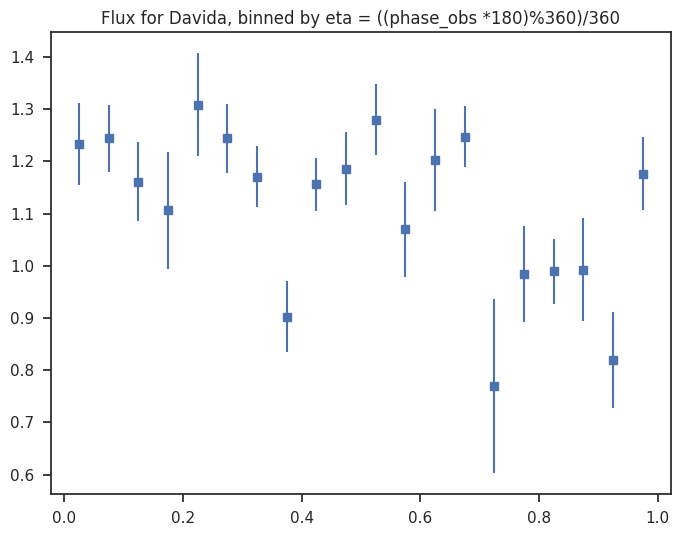

In [27]:
plt.errorbar(eta_bin, res_bin, yerr=err_bin, fmt='s', label='Bin Flux', zorder=1)
plt.title('Flux for {}, binned by eta = ((phase_obs *180)%360)/360'.format(name))

In [28]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([1., 0.5, 1., 0.5, 1., np.log(1.)])
#initial = np.array([10., 0.5, -6., np.log(1.)])
#
soln = minimize(nll, initial, args=(eta, res, error))
A1_ml, phi1_ml, A2_ml, phi2_ml, C_ml, log_f_ml = soln.x
#A1_ml, phi1_ml,  C_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("A1 = {0:.3f}".format(A1_ml))
print("phi1 = {0:.3f}".format(phi1_ml))
print("A2 = {0:.3f}".format(A2_ml))
print("phi2 = {0:.3f}".format(phi2_ml))
print("C = {0:.3f}".format(C_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

#plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
#plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
#plt.legend(fontsize=14)
#plt.xlim(0, 10)
#plt.xlabel("x")
#plt.ylabel("y");

#Wraps around phase if phi<0

if phi1_ml < 0:
    phi1_ml += 1
if phi2_ml < 0:
    phi2_ml += 1
if phi1_ml>1:
    phi1_ml -=1
if phi2_ml>1:
    phi2_ml -=1    
    
#if A1_ml < 0:
#    A1_ml = -A1_ml
#if A2_ml < 0:
#    A2_ml = -A2_ml

Maximum likelihood estimates:
A1 = -0.104
phi1 = -3.086
A2 = -0.069
phi2 = -3.562
C = 1.115
f = 0.210


In [20]:
phi2_ml

0.890182467609138

In [21]:
pos = np.array([0.0, 0.5, 0.05, 0.5, 0.95, 0.1]) + 1e-4 * np.random.randn(32, 6)
#pos = np.array([0.1, 0.5, 1, log_f_ml]) + 1e-4 * np.random.randn(32, 4)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(eta, res, err)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:05<00:00, 848.38it/s]


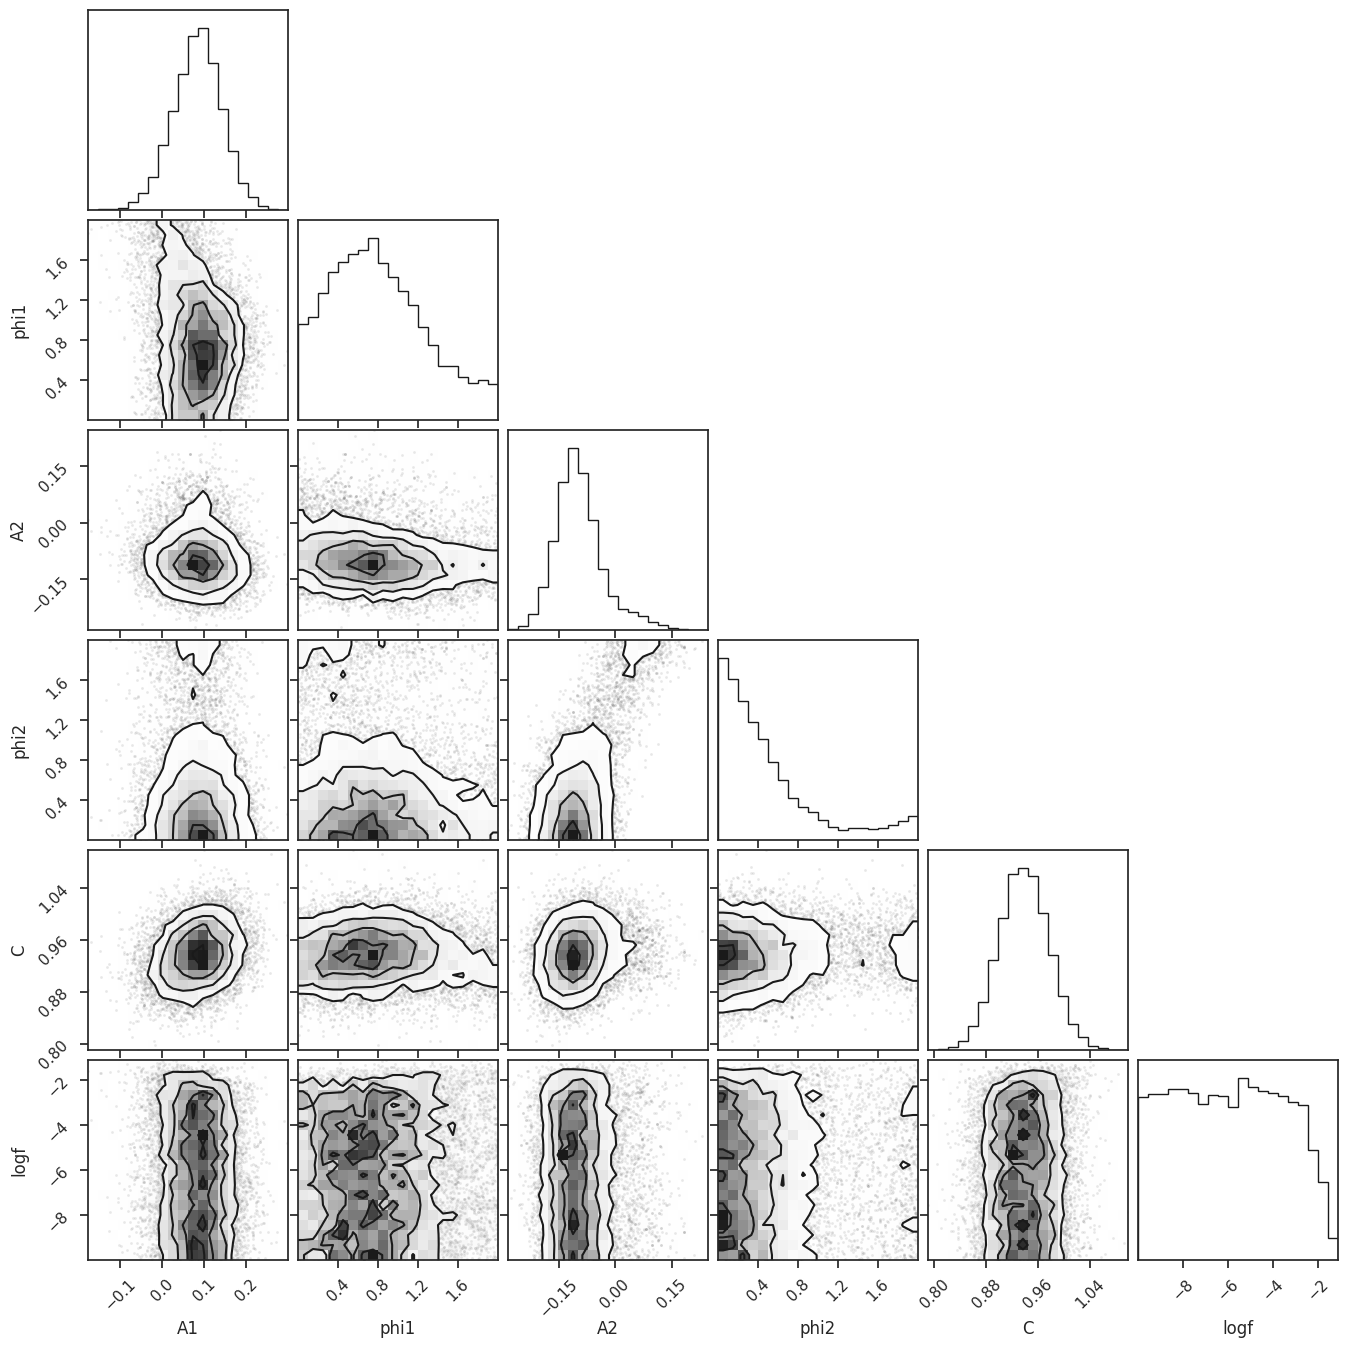

In [22]:
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ['A1', 'phi1', 'A2', 'phi2', 'C', 'logf']
#labels = ['A1', 'phi1', 'C', 'logf']

fig = corner.corner(
    flat_samples, labels=labels
);

plt.savefig('./plots/corner_{}_joint.png'.format(name))

In [23]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [27]:
def const(x, *p):
    return p
residual_const = lambda p, x, y, yerr: (const(x, *p)-y)/yerr

pf_const_bin, cov_const_bin, info, mesg, success = leastsq(residual_const, -10, 
                                    args=(np.array(eta_bin), np.array(res_bin), np.array(err_bin)), full_output=1)
pf_const, cov_const, info, mesg, success = leastsq(residual_const, -10, 
                                    args=(np.array(eta), np.array(res), np.array(error)), full_output=1)

In [28]:
diff_sin = (sin2model(eta, np.median(flat_samples[:, :-1], axis = 0)) - res)**2

chi_sqr_sin = np.sum(diff_sin / (error**2))

diff_const = (const(eta, pf_const) - res)**2
chi_sqr_const = np.sum(diff_const / (error**2))

In [29]:
red_chi_sqr_const = chi_sqr_const/(len(eta)-1)
sigma_chi = np.sqrt(2/(len(eta)-1))

In [30]:
print((red_chi_sqr_const-1)/sigma_chi)

-0.025632441984379233


In [31]:
resids = (const(eta, pf_const)[0] - res)/error

In [32]:
from scipy import stats

sigs = np.linspace(-10, 10, 100)
ps = 1-stats.norm.cdf(sigs)
pofsig = interp1d(ps, sigs)

ignore, p_val = stats.kstest(resids, stats.norm.cdf)


In [33]:
print('{} inconsistent with constant at {}'.format(name, pofsig(p_val)))

Hebe inconsistent with constant at 0.19075852185672337


In [34]:
resid_bin = (const(eta_bin, pf_const_bin)[0] - res_bin)/err_bin
ignore, p_val = stats.kstest(resid_bin, stats.norm.cdf)


In [35]:
print('Binned {} inconsistent with constant at {}'.format(name, pofsig(p_val)))

Binned Hebe inconsistent with constant at -1.1805374301722198


In [36]:
print(chi_sqr_sin, chi_sqr_const)

527.5868567766427 536.1599751693213


In [37]:
f_stat = ((chi_sqr_const-chi_sqr_sin)/(5-1))/(chi_sqr_sin/(len(eta)-5))


In [38]:
from scipy.stats import f as f_dist
nun = len(eta)-1
dun = len(eta)-5
p_value = 1 - f_dist.cdf(f_stat, nun, dun)

In [39]:
import scipy

sigs = np.linspace(-10, 10, 100)
ps = 1-scipy.stats.norm.cdf(sigs)

pofsig = interp1d(ps, sigs)
if p_value > 1: print('No detection, 2 sine, for {}'.format(name))
else: print(pofsig(p_value))

8.18181818181818


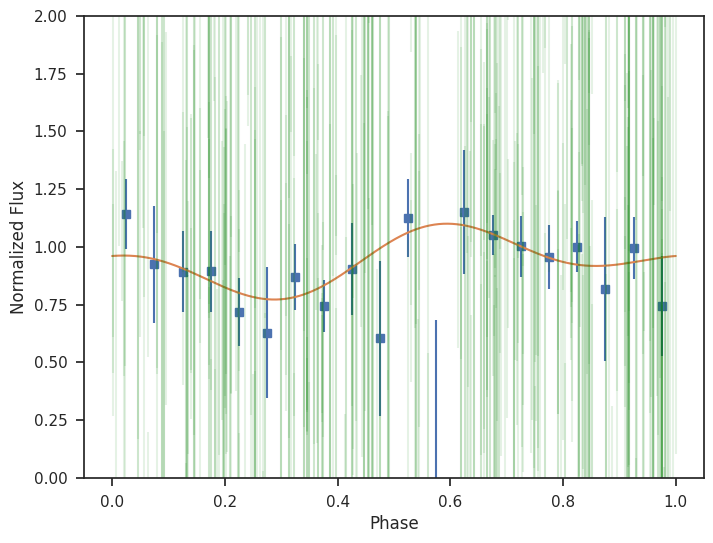

In [40]:
eta_space = np.linspace(0,1,1000)
plt.errorbar(eta_bin, res_bin, yerr=err_bin, fmt='s', label='Bin Flux', zorder=1)
plt.plot(eta_space, sin2model(eta_space, np.median(flat_samples[:, :-1], axis = 0)))
#plt.hlines(pf_const[0], -1, 2, color = 'black')
plt.errorbar(eta, res, yerr=error, linestyle='none', alpha = 0.1, color = 'green')
#plt.ylim(0.5, 1.5)
plt.ylim(0, 2)
plt.xlim(-0.05, 1.05)
plt.ylabel('Normalized Flux')
plt.xlabel('Phase')
#plt.title('Phase Curve for {}'.format(name))

if len(freqs) > 1: freq_label = 'joint'
else: freq_label = str(freq)
plt.savefig('./plots/{}_phase_{}.pdf'.format(name, freq_label))
plt.savefig('./plots/{}_phase_{}.png'.format(name, freq_label))

In [41]:
interval = 1/20
center = interval * 0.5
phase_bins = np.arange(0,1,interval)+center
diff_sin = (sin2model(eta, np.median(flat_samples[:, :-1], axis = 0)) - res)**2

adjust = np.zeros(len(err_bin))

for j, i in enumerate(np.arange(0,1,interval)):
    flags = np.where((eta>i) & (eta <= (i+interval)))[0]
    adjust[j] = np.sum(diff_sin[flags]/error[flags]**2)/len(flags)

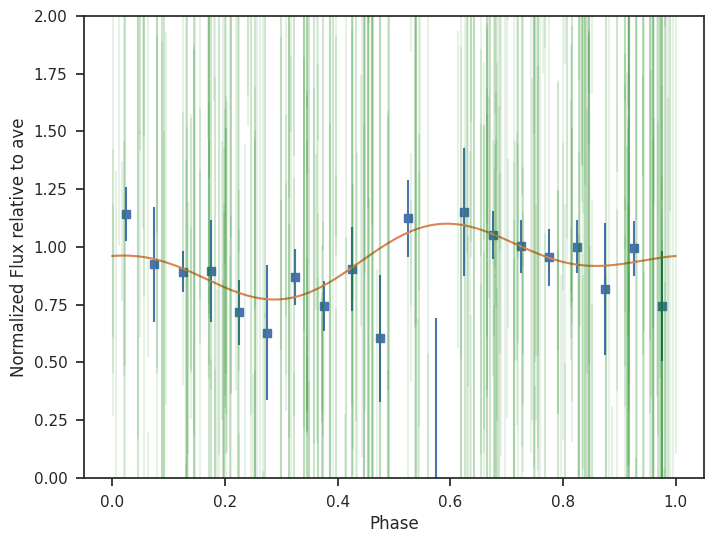

In [42]:
eta_space = np.linspace(0,1,1000)
plt.errorbar(eta_bin, res_bin, yerr=err_bin*adjust, fmt='s', label='Bin Flux', zorder=1)
plt.plot(eta_space, sin2model(eta_space, np.median(flat_samples[:, :-1], axis = 0)))
plt.errorbar(eta, res, yerr=error, linestyle='none', alpha = 0.1, color = 'green')
plt.ylim(0, 2)
plt.ylabel('Normalized Flux relative to ave')
plt.xlabel('Phase')
#plt.title('Phase Curve for {}, Adjusted Err Bar'.format(name))

if len(freqs) > 1: freq_label = 'joint'
else: freq_label = str(freq)

# Separate Freqs

In [399]:
name, phase, idx, sn, shape, pol = get_name(1)
print(name)

Vesta


In [400]:
flux_090, times_090, err_090, F_090, phi_090, theta_090, alpha_090 = get_data(name, pas, ['090'], norm = False)
flux_150, times_150, err_150, F_150, phi_150, theta_150, alpha_150 = get_data(name, pas, ['150'], norm = False)
flux_220, times_220, err_220, F_220, phi_220, theta_220, alpha_220 = get_data(name, pas, ['220'], norm = False)

In [401]:
eta_090 = get_eta(name, times_090, orientation='Prograde')
eta_150 = get_eta(name, times_150, orientation='Prograde')
eta_220 = get_eta(name, times_220, orientation='Prograde')

19231.659576000002
19231.659576000002
19231.659576000002


In [402]:
flux_bin_090, err_bin_090, eta_bin_090, n_point_090 = inv_var_weight(20, err_090, eta_090, flux_090)
flux_bin_150, err_bin_150, eta_bin_150, n_point_150 = inv_var_weight(20, err_150, eta_150, flux_150)
flux_bin_220, err_bin_220, eta_bin_220, n_point_220 = inv_var_weight(20, err_220, eta_220, flux_220)


In [403]:
pos = np.array([0.1*np.mean(flux_090), 0.5, 0.1*np.mean(flux_090), 0.5, np.mean(flux_090), 0.1]) + 1e-4 * np.random.randn(32, 6)
#pos = np.array([0.1, 0.5, 1, log_f_ml]) + 1e-4 * np.random.randn(32, 4)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(eta_090, flux_090, err_090)
)
sampler.run_mcmc(pos, 5000, progress=True);
flat_samples_090 = sampler.get_chain(discard=100, thin=15, flat=True)

100%|██████████| 5000/5000 [00:08<00:00, 567.94it/s]


In [404]:
pos = np.array([0.1*np.mean(flux_150), 0.5, 0.1*np.mean(flux_150), 0.5, np.mean(flux_150), 0.1]) + 1e-4 * np.random.randn(32, 6)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(eta_150, flux_150, err_150)
)
sampler.run_mcmc(pos, 5000, progress=True);
flat_samples_150 = sampler.get_chain(discard=100, thin=15, flat=True)

100%|██████████| 5000/5000 [00:10<00:00, 490.40it/s]


In [405]:
pos = np.array([0.1*np.mean(flux_220), 0.5, 0.1*np.mean(flux_220), 0.5, np.mean(flux_220), 0.1]) + 1e-4 * np.random.randn(32, 6)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(eta_220, flux_220, err_220)
)
sampler.run_mcmc(pos, 5000, progress=True);
flat_samples_220 = sampler.get_chain(discard=100, thin=15, flat=True)

100%|██████████| 5000/5000 [00:07<00:00, 635.08it/s]


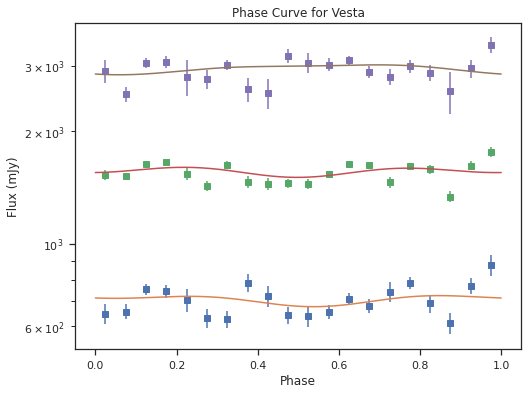

In [406]:
eta_space = np.linspace(0,1,1000)
plt.errorbar(eta_bin_090, flux_bin_090, yerr=err_bin_090, fmt='s', label='090', zorder=1)
plt.plot(eta_space, sin2model(eta_space, np.median(flat_samples_090[:, :-1], axis = 0)), label = '090 fit')
plt.errorbar(eta_bin_150, flux_bin_150, yerr=err_bin_150, fmt='s', label='150', zorder=1)
plt.plot(eta_space, sin2model(eta_space, np.median(flat_samples_150[:, :-1], axis = 0)), label = '150 fit')
plt.errorbar(eta_bin_220, flux_bin_220, yerr=err_bin_220, fmt='s', label='220', zorder=1)
plt.plot(eta_space, sin2model(eta_space, np.median(flat_samples_220[:, :-1], axis = 0)), label = '220 fit')
#plt.errorbar(eta, res, yerr=error, linestyle='none', alpha = 0.1, color = 'green')
#plt.ylim(0, 2)
#plt.legend()
plt.ylabel('Flux (mJy)')
plt.xlabel('Phase')
plt.title('Phase Curve for {}'.format(name))
plt.yscale('log')

if len(freqs) > 1: freq_label = 'joint'
else: freq_label = str(freq)

In [114]:
#res_bin[1]= np.mean(res_bin[2:])
#err_bin[1] = 1

In [104]:


diff_sin = (sin2model(eta_bin, np.median(flat_samples[:, :-1], axis = 0)) - res_bin)**2
chi_sqr_sin = np.sum(diff_sin / (err_bin**2))

diff_const = (const(eta_bin, pf_const) - res_bin)**2
chi_sqr_const = np.sum(diff_const / (err_bin**2))

In [105]:
print(chi_sqr_sin, chi_sqr_const)

133.68725250799886 140.3490646529494


In [106]:
f_stat = ((chi_sqr_const-chi_sqr_sin)/(5-1))/(chi_sqr_sin/(len(eta_bin)-5))
import scipy
nun = len(eta_bin)-1
dun = len(eta_bin)-5
p_value = 1-scipy.stats.f.cdf(f_stat, nun, dun)
print(p_value)

0.999564515012721


In [107]:
pofsig(p_value)

array(-3.33039071)

In [108]:
resids = (const(eta_bin, pf_const) - res_bin)/err_bin

In [109]:
from scipy import stats

sigs = np.linspace(-10, 10, 100)
ps = 1-stats.norm.cdf(sigs)
pofsig = interp1d(ps, sigs)

ignore, p_val = stats.kstest(resids, stats.norm.cdf)


IndexError: index 19 is out of bounds for axis 0 with size 1

In [ ]:
print('{} inconsistent with constant at {}'.format(name, pofsig(p_val)))

In [61]:
pos = np.array([-0.13, 1.8, 1, log_f_ml]) + 1e-4 * np.random.randn(32, 4)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_1s, args=(eta, res, error)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:11<00:00, 441.19it/s]


In [62]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

diff_sin = (sin1model(eta, np.median(flat_samples[:, :-1], axis = 0)) - res)**2

chi_sqr_sin = np.sum(diff_sin / (error**2))

diff_const = (const(eta, pf_const) - res)**2
chi_sqr_const = np.sum(diff_const / (error**2))

In [63]:
print(chi_sqr_sin, chi_sqr_const)

576.645929550157 600.2083523442382


In [64]:
f_stat = ((chi_sqr_const-chi_sqr_sin)/(3-1))/(chi_sqr_sin/(len(eta)-3))
nun = len(eta)-1
dun = len(eta)-3
p_value = 1-scipy.stats.f.cdf(f_stat, nun, dun)

sigs = np.linspace(-10, 10, 100)
ps = 1-scipy.stats.norm.cdf(sigs)

pofsig = interp1d(ps, sigs)

In [66]:
fstat = (576.645929550157-573.5797274074356)/(5-3)/(573.5797274074356/(len(eta)-5))

In [68]:
nun = len(eta)-5
dun = len(eta)-3
p_value = 1-scipy.stats.f.cdf(f_stat, nun, dun)

sigs = np.linspace(-10, 10, 100)
ps = 1-scipy.stats.norm.cdf(sigs)

pofsig = interp1d(ps, sigs)

In [69]:
pofsig(p_value)

array(8.18181818)

In [ ]:
print(chi_sqr_sin, chi_sqr_const)

In [ ]:
fdir = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/'
for i in range(100):
    desig, name, semimajor = get_desig(i)
    print(i, name, end = '\r')
    for fname in os.listdir(fdir):
        if name not in fname: continue
        
        
        
        with open(fdir + fname, 'rb') as f:
            lc_dict = pk.load(f)

        if 'name' in lc_dict.keys(): continue
        cur_times= np.array(lc_dict['time'])
        cur_times = Time(cur_times, format='unix')
        cur_times = cur_times.mjd

        cur_phi = rot_phase(name, cur_times) #rotation phase numbers
        phi = np.array(cur_phi)
        cur_theta, ignore_T = orb_phase(name, cur_times) #orbital phase numbers
        theta = np.array(cur_theta)
        cur_alpha = sunang_phase(name, cur_times) #solar phase angle numbers
        alpha = np.array(cur_alpha)

        lc_dict['phi'] = phi
        lc_dict['theta'] = theta
        lc_dict['alhpa'] = alpha
        lc_dict['name'] = name
        with open(fdir + fname, 'wb') as f:
            pk.dump(lc_dict, f)
    

In [ ]:
np.sqrt(6.6)

In [ ]:
scipy.stats.f.cdf(1, nun, dun)

In [ ]:
scipy.stats.f.sf(6, nun, dun)

In [355]:
sigs, p_vals, f_stats, dchis = p_dist(res, error, n=100)

0


100%|██████████| 5000/5000 [00:09<00:00, 509.66it/s]


1.0
1


100%|██████████| 5000/5000 [00:09<00:00, 529.22it/s]


0.8545803397707452
2


100%|██████████| 5000/5000 [00:09<00:00, 537.66it/s]


0.00010967632161873464
3


100%|██████████| 5000/5000 [00:09<00:00, 523.36it/s]


0.9961401369763682
4


100%|██████████| 5000/5000 [00:09<00:00, 534.24it/s]


0.9999666265756835
5


100%|██████████| 5000/5000 [00:10<00:00, 477.53it/s]


1.0
6


100%|██████████| 5000/5000 [00:09<00:00, 520.37it/s]


0.9995653266875156
7


100%|██████████| 5000/5000 [00:09<00:00, 525.65it/s]


1.0
8


100%|██████████| 5000/5000 [00:09<00:00, 516.27it/s]


0.23238796280713903
9


100%|██████████| 5000/5000 [00:09<00:00, 528.75it/s]


0.43373434529276467
10


100%|██████████| 5000/5000 [00:09<00:00, 505.83it/s]


1.683874472102609e-05
11


100%|██████████| 5000/5000 [00:09<00:00, 523.45it/s]


0.9312246707802726
12


100%|██████████| 5000/5000 [00:09<00:00, 540.68it/s]


0.9991027234033883
13


100%|██████████| 5000/5000 [00:09<00:00, 536.09it/s]


0.30624645978627907
14


100%|██████████| 5000/5000 [00:09<00:00, 536.35it/s]


0.9956665895643022
15


100%|██████████| 5000/5000 [00:09<00:00, 509.86it/s]


0.9488070680929724
16


100%|██████████| 5000/5000 [00:09<00:00, 528.49it/s]


1.0
17


100%|██████████| 5000/5000 [00:09<00:00, 508.35it/s]


0.003299184810124256
18


100%|██████████| 5000/5000 [00:09<00:00, 504.81it/s]


0.9999775527587668
19


100%|██████████| 5000/5000 [00:10<00:00, 495.66it/s]


0.48030201414265106
20


100%|██████████| 5000/5000 [00:09<00:00, 529.50it/s]


0.9999983051952266
21


100%|██████████| 5000/5000 [00:09<00:00, 502.35it/s]


0.9999999993430444
22


100%|██████████| 5000/5000 [00:09<00:00, 510.43it/s]


0.9918143534088009
23


100%|██████████| 5000/5000 [00:09<00:00, 504.82it/s]


0.030362275665666072
24


100%|██████████| 5000/5000 [00:09<00:00, 531.90it/s]


1.0
25


100%|██████████| 5000/5000 [00:09<00:00, 515.70it/s]


0.9999999999999625
26


100%|██████████| 5000/5000 [00:09<00:00, 528.31it/s]


0.9999999037205526
27


100%|██████████| 5000/5000 [00:09<00:00, 527.31it/s]


3.7270186936666505e-13
28


100%|██████████| 5000/5000 [00:09<00:00, 520.77it/s]


0.00038999989460919426
29


100%|██████████| 5000/5000 [00:09<00:00, 544.21it/s]


0.9999999900315862
30


100%|██████████| 5000/5000 [00:09<00:00, 509.38it/s]


0.05237397517209086
31


100%|██████████| 5000/5000 [00:09<00:00, 513.83it/s]


0.9999965048140282
32


100%|██████████| 5000/5000 [00:09<00:00, 526.94it/s]


0.9999999994502545
33


100%|██████████| 5000/5000 [00:09<00:00, 501.21it/s]


5.687334560489088e-05
34


100%|██████████| 5000/5000 [00:09<00:00, 508.11it/s]


5.426540474084973e-06
35


100%|██████████| 5000/5000 [00:10<00:00, 499.89it/s]


9.023061308988112e-05
36


100%|██████████| 5000/5000 [00:09<00:00, 510.71it/s]


0.00318085655834377
37


100%|██████████| 5000/5000 [00:09<00:00, 516.66it/s]


1.0
38


100%|██████████| 5000/5000 [00:09<00:00, 529.13it/s]


0.747151971996999
39


100%|██████████| 5000/5000 [00:09<00:00, 537.96it/s]


0.9993600790553377
40


100%|██████████| 5000/5000 [00:09<00:00, 526.76it/s]


0.9999994211076206
41


100%|██████████| 5000/5000 [00:09<00:00, 518.72it/s]


1.0
42


100%|██████████| 5000/5000 [00:09<00:00, 522.43it/s]


5.6288307348495437e-14
43


100%|██████████| 5000/5000 [00:09<00:00, 528.52it/s]


0.9010707370803589
44


100%|██████████| 5000/5000 [00:09<00:00, 534.56it/s]


0.9999999854458314
45


100%|██████████| 5000/5000 [00:10<00:00, 486.65it/s]


1.0
46


100%|██████████| 5000/5000 [00:09<00:00, 509.17it/s]


0.09100731997201517
47


100%|██████████| 5000/5000 [00:10<00:00, 491.51it/s]


0.09142547863814576
48


100%|██████████| 5000/5000 [00:09<00:00, 528.23it/s]


0.9235022976509749
49


100%|██████████| 5000/5000 [00:09<00:00, 530.40it/s]


0.9835505290797079
50


100%|██████████| 5000/5000 [00:09<00:00, 528.64it/s]


0.987968185911625
51


100%|██████████| 5000/5000 [00:09<00:00, 515.13it/s]


0.9995024828875649
52


100%|██████████| 5000/5000 [00:09<00:00, 530.04it/s]


0.9769523352417689
53


100%|██████████| 5000/5000 [00:10<00:00, 497.20it/s]


1.0
54


100%|██████████| 5000/5000 [00:10<00:00, 498.46it/s]


0.9999999810464165
55


100%|██████████| 5000/5000 [00:09<00:00, 518.48it/s]


0.6905181911678064
56


100%|██████████| 5000/5000 [00:09<00:00, 512.65it/s]


0.05254471645939418
57


100%|██████████| 5000/5000 [00:09<00:00, 501.50it/s]


1.5665369001993668e-09
58


100%|██████████| 5000/5000 [00:09<00:00, 526.81it/s]


0.9949080456415043
59


100%|██████████| 5000/5000 [00:09<00:00, 531.08it/s]


1.0
60


100%|██████████| 5000/5000 [00:09<00:00, 547.23it/s]


0.467785941868474
61


100%|██████████| 5000/5000 [00:09<00:00, 525.71it/s]


0.9999999999990954
62


100%|██████████| 5000/5000 [00:09<00:00, 528.38it/s]


6.956587861317587e-09
63


100%|██████████| 5000/5000 [00:09<00:00, 534.77it/s]


0.9507170471691853
64


100%|██████████| 5000/5000 [00:09<00:00, 513.51it/s]


0.9996217871096
65


100%|██████████| 5000/5000 [00:09<00:00, 510.82it/s]


2.1556645357634352e-11
66


100%|██████████| 5000/5000 [00:09<00:00, 525.88it/s]


0.9836628490881951
67


100%|██████████| 5000/5000 [00:09<00:00, 521.61it/s]


1.0
68


100%|██████████| 5000/5000 [00:09<00:00, 531.01it/s]


0.9980390207189105
69


100%|██████████| 5000/5000 [00:09<00:00, 522.79it/s]


1.0
70


100%|██████████| 5000/5000 [00:09<00:00, 543.11it/s]


0.00013987642010082624
71


100%|██████████| 5000/5000 [00:09<00:00, 528.80it/s]


0.9999999999999388
72


100%|██████████| 5000/5000 [00:09<00:00, 536.95it/s]


1.0
73


100%|██████████| 5000/5000 [00:09<00:00, 525.17it/s]


0.0007421335318322786
74


100%|██████████| 5000/5000 [00:09<00:00, 537.32it/s]


1.7902657900581431e-06
75


100%|██████████| 5000/5000 [00:09<00:00, 524.69it/s]


0.017615171324850687
76


100%|██████████| 5000/5000 [00:09<00:00, 523.87it/s]


0.8729989685141978
77


100%|██████████| 5000/5000 [00:09<00:00, 501.42it/s]


1.0
78


100%|██████████| 5000/5000 [00:09<00:00, 504.73it/s]


1.0
79


100%|██████████| 5000/5000 [00:09<00:00, 530.67it/s]


0.9999985732402612
80


100%|██████████| 5000/5000 [00:09<00:00, 529.22it/s]


0.9999999999999997
81


100%|██████████| 5000/5000 [00:09<00:00, 517.66it/s]


0.9999846517173806
82


100%|██████████| 5000/5000 [00:09<00:00, 534.27it/s]


0.9999999999999872
83


100%|██████████| 5000/5000 [00:10<00:00, 484.95it/s]


1.0
84


100%|██████████| 5000/5000 [00:09<00:00, 511.72it/s]


1.3591357291842243e-06
85


100%|██████████| 5000/5000 [00:09<00:00, 536.02it/s]


0.9999999999999951
86


100%|██████████| 5000/5000 [00:09<00:00, 529.11it/s]


0.4279777368018953
87


100%|██████████| 5000/5000 [00:09<00:00, 533.50it/s]


0.0010541309408237387
88


100%|██████████| 5000/5000 [00:09<00:00, 528.32it/s]


8.767849277258044e-05
89


100%|██████████| 5000/5000 [00:09<00:00, 524.82it/s]


1.0
90


100%|██████████| 5000/5000 [00:09<00:00, 516.50it/s]


1.166354448134399e-06
91


100%|██████████| 5000/5000 [00:09<00:00, 545.58it/s]


5.684857029564228e-10
92


100%|██████████| 5000/5000 [00:08<00:00, 558.20it/s]


1.0
93


100%|██████████| 5000/5000 [00:08<00:00, 567.21it/s]


0.8876891259300359
94


100%|██████████| 5000/5000 [00:09<00:00, 544.05it/s]


1.40980926932599e-09
95


100%|██████████| 5000/5000 [00:08<00:00, 557.54it/s]


1.3099678008998694e-09
96


100%|██████████| 5000/5000 [00:09<00:00, 537.59it/s]


0.015647703294466075
97


100%|██████████| 5000/5000 [00:09<00:00, 541.23it/s]


0.0020469526887618716
98


100%|██████████| 5000/5000 [00:08<00:00, 557.01it/s]


0.00018258139441462706
99


100%|██████████| 5000/5000 [00:09<00:00, 534.45it/s]

2.1239978814646676e-06


(array([ 7., 57.,  3.,  5.,  5.,  8.,  6.,  1.,  5.,  3.]),
 array([-1.6334219 , -0.72752137,  0.17837917,  1.08427971,  1.99018025,
         2.89608079,  3.80198133,  4.70788186,  5.6137824 ,  6.51968294,
         7.42558348]),
 <BarContainer object of 10 artists>)

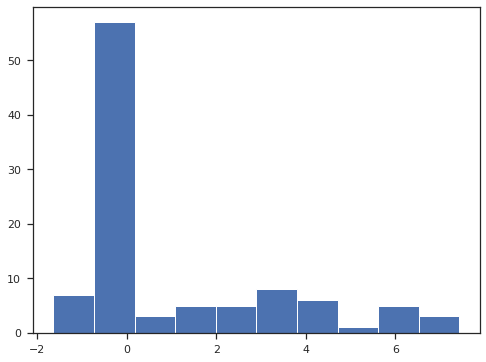

In [357]:
plt.hist(sigs)

Text(0, 0.5, 'count')

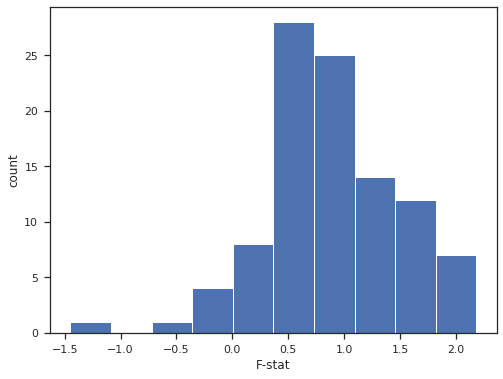

In [363]:
plt.hist(f_stats)
plt.xlabel('F-stat')
plt.ylabel('count')

In [370]:
with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/phase_stats.pk', 'rb') as f:
    
    stats_dict = pk.load(f)

In [372]:
stats_dict['sigs']

array([  0.,   0.,   0., ...,   0., -10.,   0.])

In [114]:
name = 'Juno'

cur_times = ['2013-01-01T00:00:00', '2013-01-02T00:00:00']
cur_times = Time(cur_times, format='isot', scale='utc')
dt = cur_times[1] - cur_times[0]
cur_times = cur_times[0] + dt * np.linspace(0., 3650, 3651*24)

#cur_times = Time([56791.0], format='mjd', scale='utc')
phi = rot_phase(name, cur_times)
theta = orb_phase(name, cur_times) #orbital phase numbers

137754426.51699647


In [115]:
cur_times_sun = utils.ctime2djd(cur_times.unix)


In [116]:
sun = ephem.Sun()
cur_times_sun = utils.ctime2djd(cur_times.unix)

pos_sun = np.zeros((3, len(cur_times_sun)))
for i in range(len(cur_times_sun)):
    
    site = ephem.Observer()
    site.lon = -67.7876*utils.degree
    site.lat = -22.9585*utils.degree
    site.elevation = 5188
    site.date = cur_times_sun[i]
    sun.compute(site)
    #print(site.date)
    pos_sun[...,i] = np.array([sun.a_ra, sun.a_dec, sun.earth_distance])

In [117]:
pos_sun/utils.degree

array([[281.47462072, 281.52059041, 281.56655795, ..., 278.54406319,
        278.5901677 , 278.63627041],
       [-23.01848805, -23.01512312, -23.0117449 , ..., -23.20402299,
        -23.20150688, -23.19897733],
       [ 56.33901686,  56.33947448,  56.33984673, ...,  56.34368871,
         56.34414975,  56.34459371]])

In [118]:
info    = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/{}.npy'.format(name.capitalize())).view(np.recarray)
orbit   = interp1d(info.ctime, [utils.unwind(info.ra*utils.degree), info.dec*utils.degree, info.r], kind=3)
pos_ast = orbit(cur_times.unix)

In [119]:
v_ea    = utils.ang2rect([pos_ast[0], pos_ast[1]])*pos_ast[2]
v_es    = utils.ang2rect([pos_sun[0], pos_sun[1]])*pos_sun[2]
# Sun-to-earth vector and Sun-to-asteroid vectors
v_se    = -v_es
v_sa    = v_se + v_ea
# Back to coordinates, which will now be sun-centered equatorial coordinates
sequ_earth = utils.rect2ang(v_se)
sequ_ast   = utils.rect2ang(v_sa)
# To equatorial coordinates
ecl_earth = coordinates.transform("equ", "ecl", sequ_earth)
ecl_ast   = coordinates.transform("equ", "ecl", sequ_ast)

In [121]:
phase_raw  = 2*np.pi*(cur_times.unix)/period
delta_t    = pos_ast[2]*utils.AU/utils.c
phase_raw -= 2*np.pi*delta_t/period # light travel time correction
delta_lon  = ecl_ast[0] - ecl_earth[0]
alpha      = np.arcsin(pos_sun[2]/pos_ast[2] * np.sin(delta_lon))
phase_obs  = phase_raw - alpha - utils.unwind(ecl_ast[0]) + np.pi

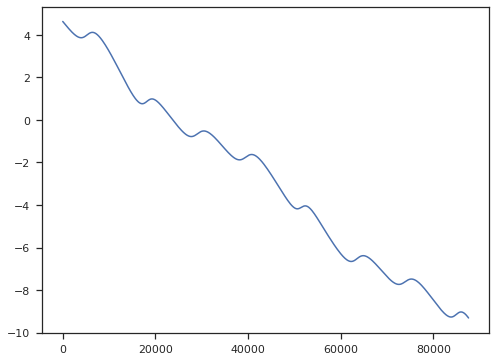

In [123]:
plt.plot(phase_obs-phase_raw)

In [381]:
eta = (phi - theta +alpha) 


In [377]:
(-alpha-ecl_ast[0]+np.pi)/utils.degree

array([-94.48820788, -94.50347301, -94.51873309, ..., 186.41416014,
       186.39716287, 186.38015596])

In [378]:
raw_phase(name, cur_times)/utils.degree

25956.0


array([18821059.63938974, 18821109.55693541, 18821159.47448107, ...,
       23194884.88058134, 23194934.79812701, 23194984.71567268])

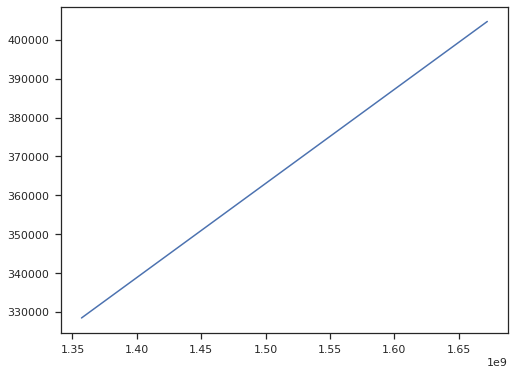

In [383]:

plt.plot(cur_times.unix, eta)
#plt.plot( (-alpha - utils.unwind(ecl_ast[0])+np.pi)/utils.degree)

In [274]:
ctime = 1400025600 

info    = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/{}.npy'.format(name.capitalize())).view(np.recarray)
orbit   = interp1d(info.ctime, [utils.unwind(info.ra*utils.degree), info.dec*utils.degree, info.r], kind=3)

In [276]:
ctime_orbt = orbit(ctime)

In [ ]:
ctime_orbt

In [358]:
(raw_phase(name, cur_times) -alpha - utils.unwind(ecl_ast[0])+np.pi)

25956.0


array([328494.09347654, 328494.96443564, 328495.83539483, ...,
       404817.79795745, 404818.66888632, 404819.53981502])

In [217]:
periods = np.zeros(1000)

for i in range(200):
    
    desig, name, semimajor = get_desig(i)
    periods[i] = get_period(name)
    print(i, periods[i]*3600)
with open('ast_periods.pk', 'wb') as f:
    pk.dump(periods, f)

0 19231.659576000002
1 32667.012000000002
2 28127.59704
3 25956.0
4 25700.4
5 26188.2
6 21898.8
7 18972.0
8 41652.0
9 46314.0
10 18284.399999999998
11 19411.56
12 33858.0
13 29152.800000000003
14 49780.799999999996
15 54100.8
16 16923.6
17 18496.8
18 37469.520000000004
19 40993.200000000004
20 49393.44
21 15105.599999999999
22 105948.0
23 31175.640000000003
24 23119.2
25 551856.6
26 49050.0
27 15397.2
28 31417.2
29 60501.600000000006
30 32076.0
31 25606.800000000003
32 44323.2
33 37069.200000000004
34 25362.0
35 19386.0
36 93240.0
37 18466.92
38 14933.88
39 26795.52
40 48924.0
41 26067.6
42 29395.8
43 82175.76
44 49269.6
45 33472.8
46 53452.8
47 35762.76
48 20743.847999999998
49 20269.44
50 17845.920000000002
51 86419.8
52 129110.4
53 21556.800000000003
54 28018.800000000003
55 26400.6
56 50508.0
57 19908.0
58 30002.399999999998
59 21751.2
60 14095.44
61 35017.200000000004
62 56541.6
63 86918.4
64 57387.600000000006
65 21520.8
66 44173.727999999996
67 56444.4
68 126540.0
69 20358.0
70 

In [140]:
with open('ast_periods.pk', 'rb') as f:
        periods = pk.load(f)
period = periods[5]
period *= 60 * 60

print(period)


26188.2


0.0


/tmp/ipykernel_217763/3006651426.py:91: RuntimeWarning: divide by zero encountered in true_divide
  phase_raw  = 2*np.pi*(ts)/period
/tmp/ipykernel_217763/3006651426.py:93: RuntimeWarning: divide by zero encountered in true_divide
  phase_raw -= 2*np.pi*delta_t/period # light travel time correction
/tmp/ipykernel_217763/3006651426.py:93: RuntimeWarning: invalid value encountered in subtract
  phase_raw -= 2*np.pi*delta_t/period # light travel time correction


<ErrorbarContainer object of 3 artists>

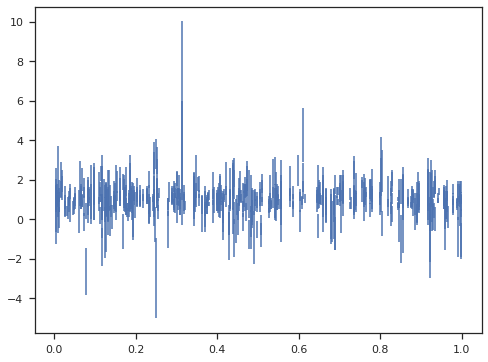

In [214]:
desig, name, semimajor = get_desig(14)

pas = [ 'pa5', 'pa4', 'pa6']
freqs = ['090', '150', '220']

flux = np.array([])
times = np.array([])
err = np.array([])
F = np.array([])
phi = np.array([])
theta = np.array([])
alpha = np.array([])
for freq in freqs:
    for pa in pas:
        try:
            with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/{}_lc_{}_{}_{}.pk'.format(name, 'night', pa, freq), 'rb') as f:
                lc_dict = pk.load(f)

            cur_F = np.array(lc_dict['F'])
            cur_flux = np.array(lc_dict['flux'])
            norm = np.mean(cur_flux*cur_F)

            cur_flux = cur_flux*cur_F/norm

            cur_err = np.array(lc_dict['err'])
            cur_err = cur_err*cur_F/norm

            flux = np.hstack([flux, cur_flux])
            cur_times= np.array(lc_dict['time'])
            cur_times = Time(cur_times, format='unix')
            cur_times = cur_times.mjd

            times = np.hstack([times, np.array(cur_times)])

            err = np.hstack([err, cur_err])
            F = np.hstack([F, cur_F])


        except FileNotFoundError: continue

times = Time(times, format='mjd')

sun = ephem.Sun()
cur_times_sun = utils.ctime2djd(times.unix)

pos_sun = np.zeros((3, len(cur_times_sun)))
for i in range(len(cur_times_sun)):

    site = ephem.Observer()
    site.lon = -67.7876*utils.degree
    site.lat = -22.9585*utils.degree
    site.elevation = 5188
    site.date = cur_times_sun[i]
    sun.compute(site)
    #print(site.date)
    pos_sun[...,i] = np.array([sun.a_ra, sun.a_dec, sun.earth_distance])
ts    = times.unix
# Load ephemeris and evaluate
info    = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/{}.npy'.format(name.capitalize())).view(np.recarray)
orbit   = interp1d(info.ctime, [utils.unwind(info.ra*utils.degree), info.dec*utils.degree, info.r], kind=3)
pos_ast = orbit(ts)
# Get the Sun's position too

# At this point we have everything in Site-relative equatorial coordinates.
# But we want the asteroid and Earth in Sun-relative ecliptic coordinates.
# Start by transforming to Sun-relative coordinates
# Earth-to-asteroid vector and Earth-to-sun vector
v_ea    = utils.ang2rect([pos_ast[0], pos_ast[1]])*pos_ast[2]
v_es    = utils.ang2rect([pos_sun[0], pos_sun[1]])*pos_sun[2]
# Sun-to-earth vector and Sun-to-asteroid vectors
v_se    = -v_es
v_sa    = v_se + v_ea
# Back to coordinates, which will now be sun-centered equatorial coordinates
sequ_earth = utils.rect2ang(v_se)
sequ_ast   = utils.rect2ang(v_sa)
# To equatorial coordinates
ecl_earth = coordinates.transform("equ", "ecl", sequ_earth)
ecl_ast   = coordinates.transform("equ", "ecl", sequ_ast)

# We're now ready to compute the observed phase angle
#orbital period in days
with open('ast_periods.pk', 'rb') as f:
    periods = pk.load(f)
period = periods[14]
period *= 60 * 60

print(period)



phase_raw  = 2*np.pi*(ts)/period
delta_t    = pos_ast[2]*utils.AU/utils.c
phase_raw -= 2*np.pi*delta_t/period # light travel time correction
delta_lon  = ecl_ast[0] - ecl_earth[0]
alpha      = np.arcsin(pos_sun[2]/pos_ast[2] * np.sin(delta_lon))
phase_obs  = raw_phase(name, times, period) - alpha - utils.unwind(ecl_ast[0]) + np.pi
#phase_obs_2 = phase_raw - alpha - utils.unwind(ecl_ast[0]) + np.pi
phase_obs *= 180/np.pi
eta = phase_obs %360
eta /= 360

flux_bin, err_bin, eta_bin = inv_var_weight(20, err, eta, flux)
flux_bin, err_bin, eta_bin = np.array(flux_bin), np.array(err_bin), np.array(eta_bin)

plt.errorbar(eta, flux, yerr=err, linestyle = 'none')


In [67]:
with open('ast_periods.pk', 'rb') as f:
    periods = pk.load(f)

In [68]:
periods[5]*60*60

26188.199999999997

In [546]:

times = ['2013-01-01T00:00:00', '2013-01-02T00:00:00']
times = Time(times, format='isot', scale='utc')
dt = times[1] - times[0]
times = times[0] + dt * np.linspace(0., 3650, 3651*24)

In [547]:
sun = ephem.Sun()
cur_times_sun = utils.ctime2djd(times.unix)

pos_sun = np.zeros((3, len(cur_times_sun)))
for i in range(len(cur_times_sun)):
    
    site = ephem.Observer()
    site.lon = -67.7876*utils.degree
    site.lat = -22.9585*utils.degree
    site.elevation = 5188
    site.date = cur_times_sun[i]
    sun.compute(site)
    #print(site.date)
    pos_sun[...,i] = np.array([sun.a_ra, sun.a_dec, sun.earth_distance])

In [548]:
moon = ephem.Moon()
cur_times_moon = utils.ctime2djd(times.unix)

pos_moon = np.zeros((3, len(cur_times_moon)))
for i in range(len(cur_times_sun)):
    
    site = ephem.Observer()
    site.lon = -67.7876*utils.degree
    site.lat = -22.9585*utils.degree
    site.elevation = 5188
    site.date = cur_times_moon[i]
    moon.compute(site)
    #print(site.date)
    pos_moon[...,i] = np.array([moon.a_ra, moon.a_dec, moon.earth_distance])

In [549]:
# Times to evaluate
ts    = times.unix


# At this point we have everything in Site-relative equatorial coordinates.
# But we want the asteroid and Earth in Sun-relative ecliptic coordinates.
# Start by transforming to Sun-relative coordinates
# Earth-to-asteroid vector and Earth-to-sun vector
v_em    = utils.ang2rect([pos_moon[0], pos_moon[1]])*pos_moon[2]
v_es    = utils.ang2rect([pos_sun[0], pos_sun[1]])*pos_sun[2]
# Sun-to-earth vector and Sun-to-asteroid vectors
v_se    = -v_es
v_sm    = v_se + v_em
# Back to coordinates, which will now be sun-centered equatorial coordinates
sequ_earth = utils.rect2ang(v_se)
sequ_moon   = utils.rect2ang(v_sm)
# To equatorial coordinates
ecl_earth = coordinates.transform("equ", "ecl", sequ_earth)
ecl_moon   = coordinates.transform("equ", "ecl", sequ_moon)

period = 27.32 #Days
period *= 60 * 60 *24

print(period)

reftime = ['2013-01-01T00:00:00']

phase_raw  = 2*np.pi*(ts)/period
delta_t    = pos_moon[2]*utils.AU/utils.c
phase_raw -= 2*np.pi*delta_t/period # light travel time correction
delta_lon  = ecl_moon[0] - ecl_earth[0]
alpha      = np.arcsin(pos_sun[2]/pos_moon[2] * np.sin(delta_lon))
#phase_obs  = raw_phase(name, times) - alpha - utils.unwind(ecl_moon[0]) + np.pi
phase_obs = -phase_raw - alpha - utils.unwind(ecl_moon[0]) + np.pi
phase_obs *= 180/np.pi
eta = phase_obs %360
eta /= 360

2360448.0


In [550]:
pos_ast = pos_moon
# Get the Sun's position too

# At this point we have everything in Site-relative equatorial coordinates.
# But we want the asteroid and Earth in Sun-relative ecliptic coordinates.
# Start by transforming to Sun-relative coordinates
# Earth-to-asteroid vector and Earth-to-sun vector
v_ea    = utils.ang2rect([pos_ast[0], pos_ast[1]])*pos_ast[2]
v_es    = utils.ang2rect([pos_sun[0], pos_sun[1]])*pos_sun[2]
# Sun-to-earth vector and Sun-to-asteroid vectors
v_se    = -v_es
v_sa    = v_se + v_ea
# Back to coordinates, which will now be sun-centered equatorial coordinates
sequ_earth = utils.rect2ang(v_se)
sequ_ast   = utils.rect2ang(v_sa)
# To equatorial coordinates
ecl_earth = coordinates.transform("equ", "ecl", sequ_earth)
ecl_ast   = coordinates.transform("equ", "ecl", sequ_ast)

# We're now ready to compute the observed phase angle

period = 27.322#29.53#27.32 #Days
period *= 60 * 60 *24

print(period)

reftime = ['2013-01-01T00:00:00']
'''
phase_raw  = 2*np.pi*(ts)/period
delta_t    = pos_ast[2]*utils.AU/utils.c
phase_raw -= 2*np.pi*delta_t/period # light travel time correction
delta_lon  = ecl_ast[0] - ecl_earth[0]

delta_lon_new = utils.vec_angdist(v_sa, v_se)

#alpha_wrong   = np.arcsin(pos_sun[2]/pos_ast[2] * np.sin(delta_lon))
#phase_obs  = raw_phase(name, times) - alpha - utils.unwind(ecl_ast[0]) +np.pi
r_a = np.linalg.norm(v_sa, axis = 0)
sin_alpha = pos_sun[2]/pos_ast[2]*np.sin(delta_lon)
sin_alpha_new = pos_sun[2]/pos_ast[2]*np.sin(delta_lon_new)
cos_alpha = (pos_ast[2]**2+r_a**2-pos_sun[2]**2)/(2*r_a*pos_ast[2])

alpha = np.arctan2(sin_alpha, cos_alpha)
alpha_new = np.arctan2(sin_alpha_new, cos_alpha)
#alpha_new = np.arcsin(sin_alpha_new)

phase_obs = phase_raw - utils.unwind(alpha) -utils.unwind(ecl_ast[0]) + np.pi
#phase_obs_wrong = phase_raw - utils.unwind(alpha)# -utils.unwind(ecl_ast[0]) + np.pi
#phase_obs_wrong = phase_raw - utils.unwind(alpha_new) -utils.unwind(ecl_ast[0]) + np.pi
'''
phase_raw  = 2*np.pi*(ts)/period
delta_t    = pos_ast[2]*utils.AU/utils.c
phase_raw -= 2*np.pi*delta_t/period # light travel time correction
delta_lon  = ecl_ast[0] - ecl_earth[0]
alpha_wrong   = np.arcsin(pos_sun[2]/pos_ast[2] * np.sin(delta_lon))
#phase_obs  = raw_phase(name, times) - alpha - utils.unwind(ecl_ast[0]) +np.pi
r_a = np.linalg.norm(v_sa, axis = 0)
sin_alpha = pos_sun[2]/pos_ast[2]*np.sin(delta_lon)
cos_alpha = (pos_ast[2]**2+r_a**2-pos_sun[2]**2)/(2*r_a*pos_ast[2])

alpha = np.arctan2(sin_alpha, cos_alpha)
#phase_obs  = raw_phase(name, times) - alpha - utils.unwind(ecl_ast[0]) + np.pi
phase_obs = phase_raw - utils.unwind(alpha) -utils.unwind(ecl_ast[0]) + np.pi

#phase_obs *= 180/np.pi
#eta = phase_obs %360
#eta /= 360

2360620.8


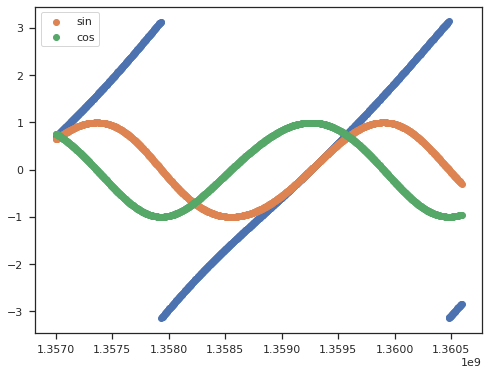

In [551]:
plt.scatter(ts[:1000], np.arctan2(sin_alpha, cos_alpha)[:1000])
#plt.scatter(ts[:200], np.arcsin(sin_alpha)[:200])
plt.scatter(ts[:1000], sin_alpha[:1000], label = 'sin')
plt.scatter(ts[:1000], cos_alpha[:1000], label = 'cos')
plt.legend()

Text(0, 0.5, 'deg')

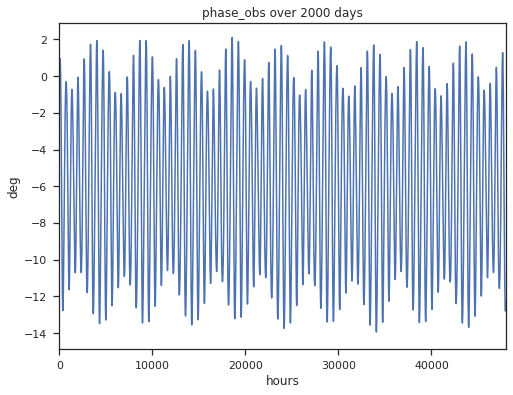

In [382]:
#plt.plot((utils.unwind(alpha)-utils.unwind(alpha)[0])*180/np.pi)
plt.plot((phase_obs-phase_obs[0])*180/np.pi)
plt.xlim(0,1*24*2000)
#plt.ylim(-20, 10)
plt.title('phase_obs over 2000 days')
plt.xlabel('hours')
plt.ylabel('deg')


Text(0, 0.5, 'phase obs (deg)')

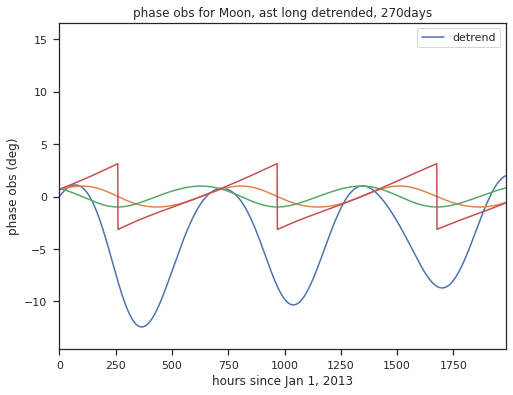

In [324]:
phase_plot = (phase_obs-phase_obs[0])
phase_plot *=180/np.pi

phase_plot -= np.linspace(0, len(phase_plot),len(phase_plot)) * phase_plot[-1]/len(phase_plot)

#phase_plot_wrong = (phase_obs_wrong-phase_obs_wrong[0])
#phase_plot_wrong *=180/np.pi

#phase_plot_wrong -= np.linspace(0, len(phase_plot_wrong),len(phase_plot_wrong)) * phase_plot_wrong[-1]/len(phase_plot_wrong)

plt.plot(phase_plot, label = 'detrend')
#plt.plot((phase_obs-phase_obs[0])*180/np.pi, label = 'phase obs')

plt.plot(sin_alpha)
plt.plot(cos_alpha)
plt.plot(alpha)
#plt.plot(phase_plot_wrong, label = 'without ast long')
#plt.plot((r_a-r_a[0])*1000)


#plt.plot(phase_plot -phase_plot_wrong)

#plt.plot((utils.unwind(ecl_ast[0]) - utils.unwind(ecl_ast[0])[0])*-180/np.pi, label = 'ast long')
#plt.plot(phase_obs_wrong*180/np.pi, label = 'arcsin')
plt.legend()

plt.xlabel('hours since Jan 1, 2013')
plt.title('phase obs for Moon, ast long detrended, 270days')
plt.xlim(0,27.54*24*3)
#plt.ylim(-15, 15 )
#plt.ylim(-3633*180/np.pi, -3610*180/np.pi)

plt.ylabel('phase obs (deg)')

(0.0, 70896.0)

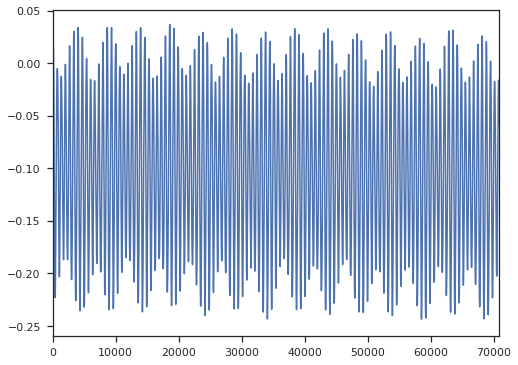

In [355]:
plt.plot(phase_obs-phase_obs[0], label = 'phase obs')
plt.xlim(0,29.54*24*100)


Text(0, 0.5, 'phase obs (deg)')

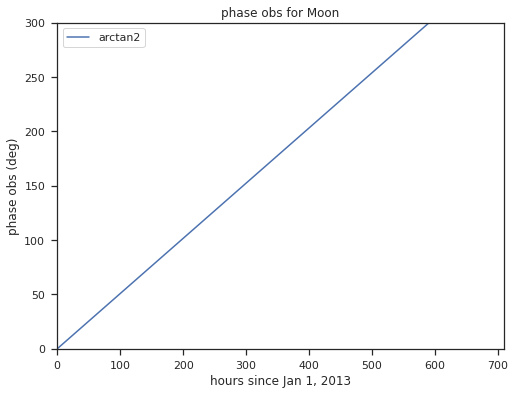

In [20]:
plt.plot((phase_raw-phase_raw[0])*180/np.pi, label = 'arctan2')
#plt.plot((utils.unwind(ecl_ast[0]) - utils.unwind(ecl_ast[0])[0])*-180/np.pi, label = 'ast long')
#plt.plot(phase_obs_wrong*180/np.pi, label = 'arcsin')
plt.legend()

plt.xlabel('hours since Jan 1, 2013')
plt.title('phase obs for Moon')
plt.xlim(0,29.54*24*1)
plt.ylim(0,300 )
#plt.ylim(-3633*180/np.pi, -3610*180/np.pi)

plt.ylabel('phase obs (deg)')

In [21]:
#plt.plot(phase_obs_2*180/np.pi)
#plt.xlabel('hours since Jan 1, 2013')
#plt.title('phase obs for Vesta')
#plt.xlim(0,40)
#plt.ylim(443350*180/np.pi, 443400*180/np.pi)
#plt.ylabel('phase obs (deg)')

Text(0, 0.5, 'deg')

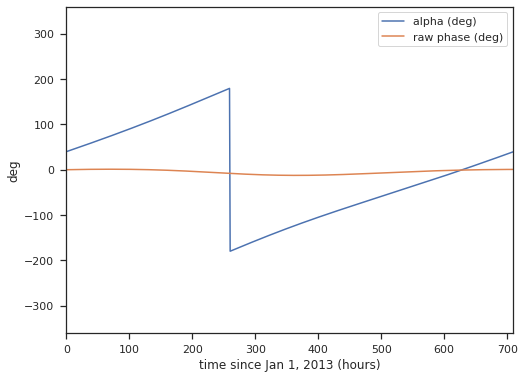

In [277]:
plt.plot(alpha*180/np.pi, label = 'alpha (deg)')
plt.plot((phase_obs-phase_obs[0])*180/np.pi, label = 'raw phase (deg)')
plt.legend()

plt.xlim(0,29.54*24)
plt.ylim(-360, 360)
plt.xlabel('time since Jan 1, 2013 (hours)')
plt.ylabel('deg')

Text(0, 0.5, 'raw phase')

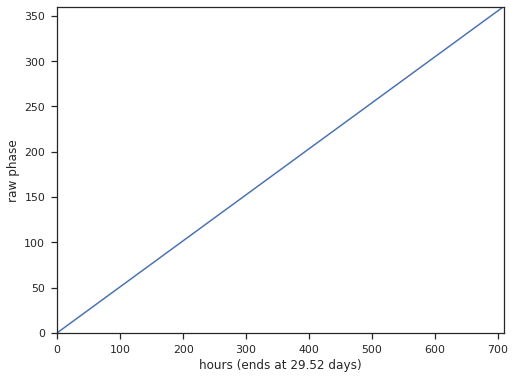

In [273]:
plt.plot((phase_raw-phase_raw[0])*180/np.pi)
plt.xlim(0,29.54*24)
plt.ylim(0, 360)
plt.xlabel('hours (ends at 29.52 days)')
plt.ylabel('raw phase')

Text(0.5, 1.0, 'Full ang = - alpha - utils.unwind(ecl_ast[0]) + np.pi')

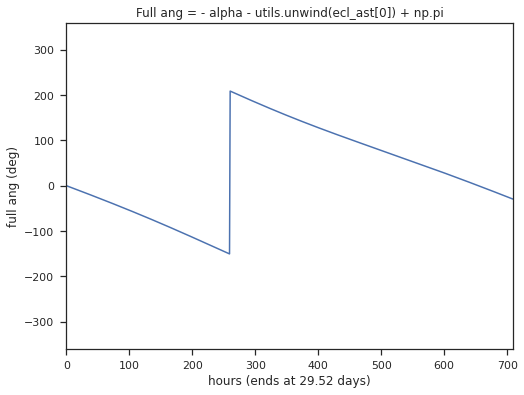

In [260]:
full_ang = - alpha - utils.unwind(ecl_ast[0]) + np.pi

plt.plot((full_ang-full_ang[0])*180/np.pi)
plt.xlim(0,29.54*24)
plt.ylim(-360, 360)
plt.xlabel('hours (ends at 29.52 days)')
plt.ylabel('full ang (deg)')
plt.title('Full ang = - alpha - utils.unwind(ecl_ast[0]) + np.pi')

Text(0.5, 1.0, 'ecl ast')

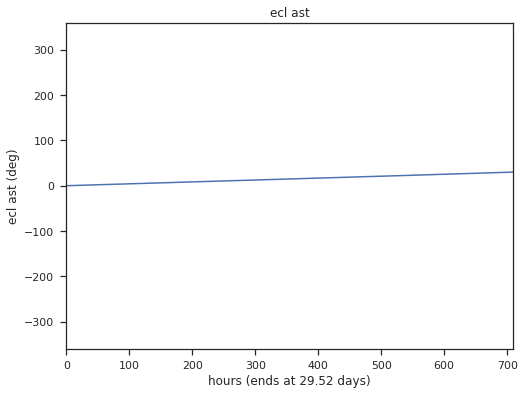

In [261]:
plt.plot((utils.unwind(ecl_ast[0])-utils.unwind(ecl_ast[0])[0])*180/np.pi)
plt.xlim(0,29.54*24)
plt.ylim(-360, 360)
plt.xlabel('hours (ends at 29.52 days)')
plt.ylabel('ecl ast (deg)')
plt.title('ecl ast')

Text(0.5, 1.0, 'alpha ')

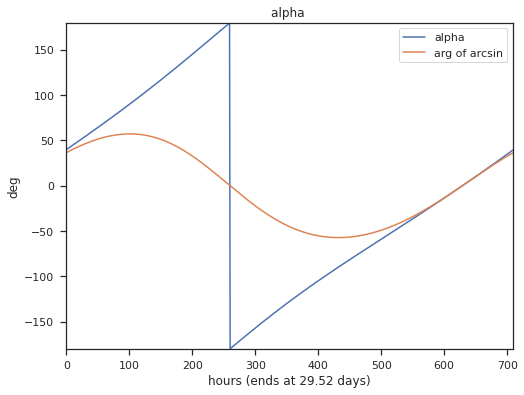

In [262]:
plt.plot(alpha*180/np.pi, label = 'alpha')
#plt.plot(delta_lon*180/np.pi, label = 'delta lon')
plt.plot((pos_sun[2]/pos_ast[2] * np.sin(delta_lon))*180/np.pi, label='arg of arcsin')
plt.xlim(0,29.54*24)
plt.ylim(-180, 180)
plt.legend()
plt.xlabel('hours (ends at 29.52 days)')
plt.ylabel('deg')
plt.title('alpha ')

In [263]:
delta_lon

array([ 0.0017263 ,  0.00173653,  0.00174637, ..., -0.00253247,
       -0.0025348 , -0.00253949])

(0.0, 7089.6)

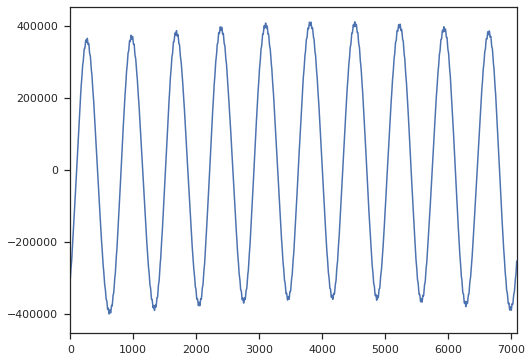

In [264]:
plt.plot((pos_sun[2]-r_a)*1.496e+8)
plt.xlim(0,29.54*24*10)


In [150]:
np.amax(pos_sun[2]-r_a)

0.002754132599649184

(0.0, 360.0)

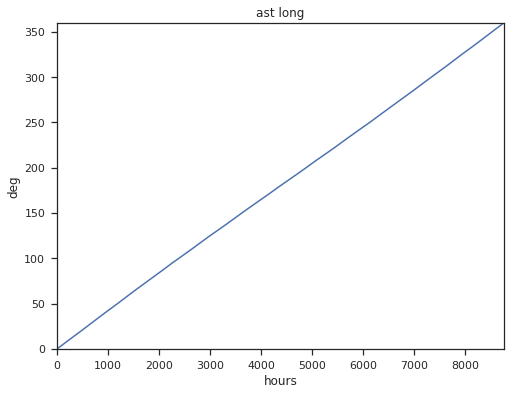

In [299]:
plt.plot((utils.unwind(ecl_ast[0])-utils.unwind(ecl_ast[0])[0])*180/np.pi)
plt.title('ast long')
plt.xlabel('hours')
plt.ylabel('deg')
plt.xlim(0,365*24)
plt.ylim(0,1*360)

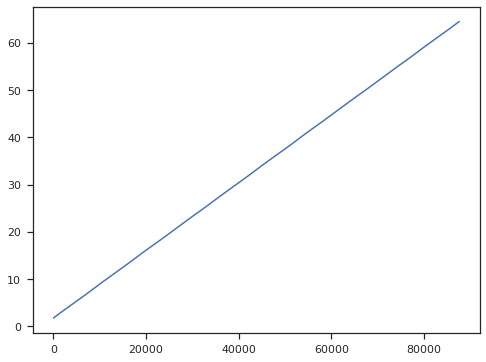

In [247]:
plt.plot(utils.unwind(ecl_ast[0]))

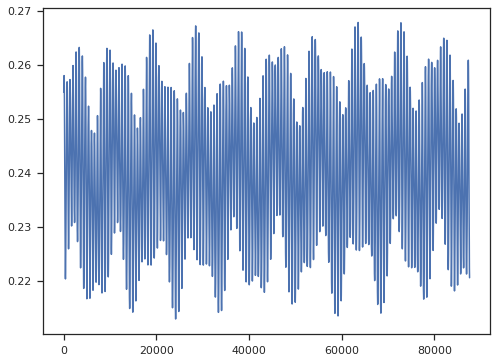

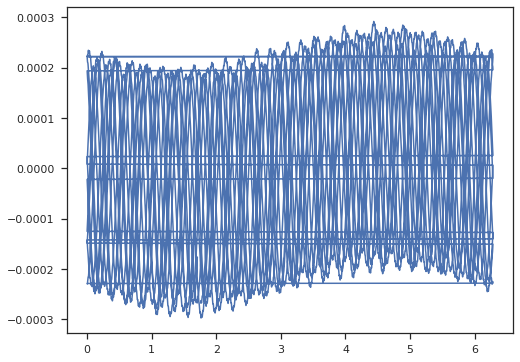

In [294]:
plt.plot(ecl_ast[0], ecl_ast[1])

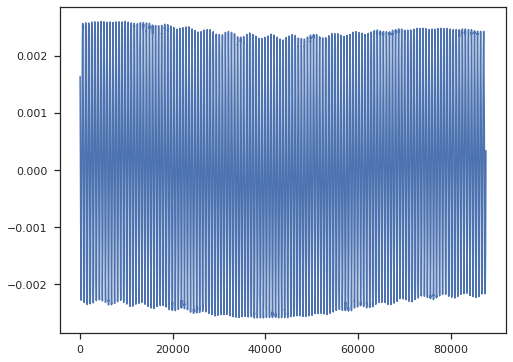

In [557]:
plt.plot(v_ea[1])

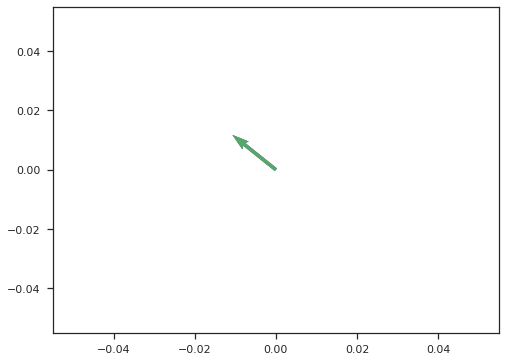

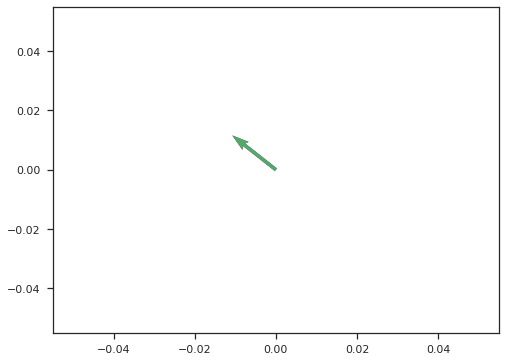

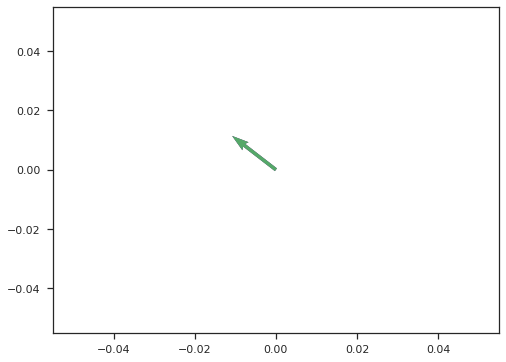

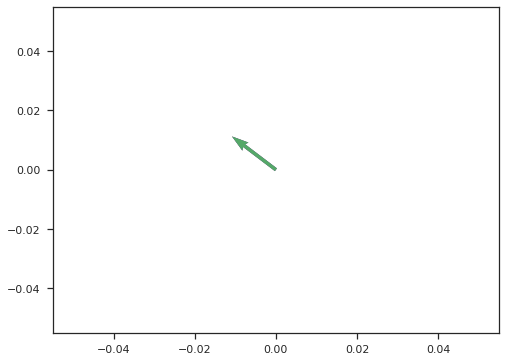

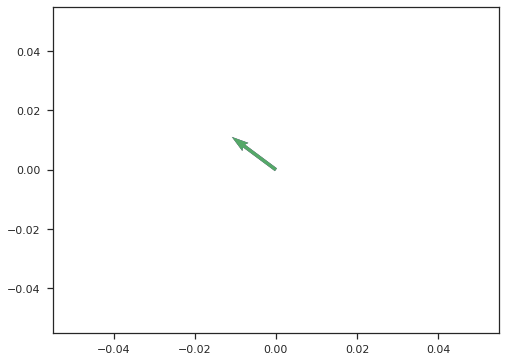

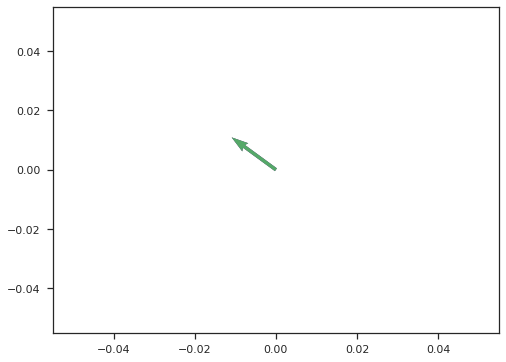

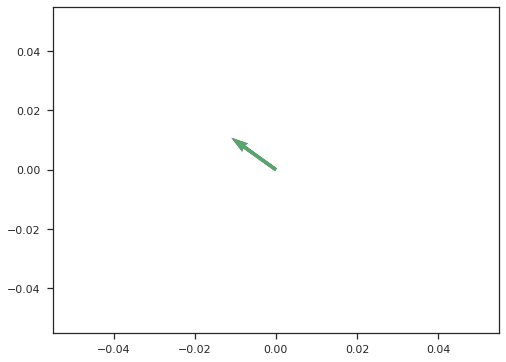

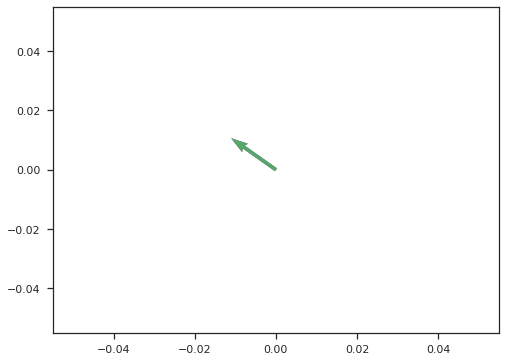

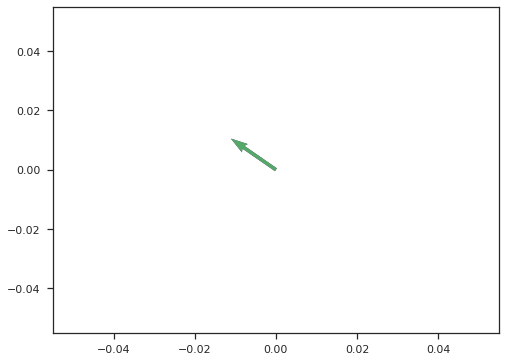

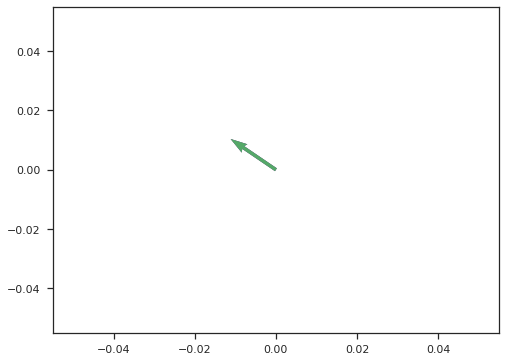

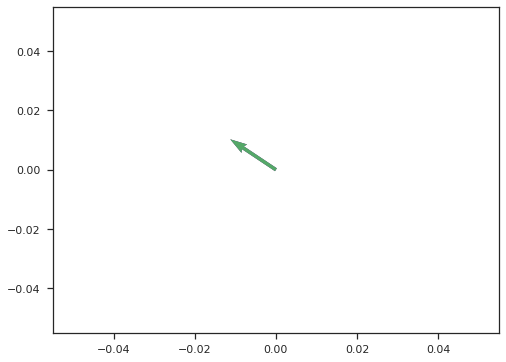

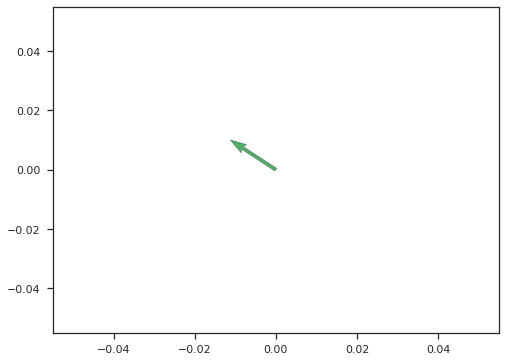

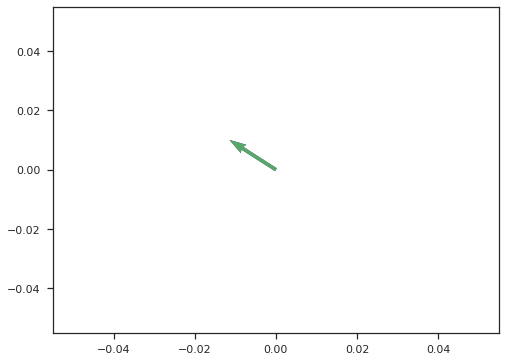

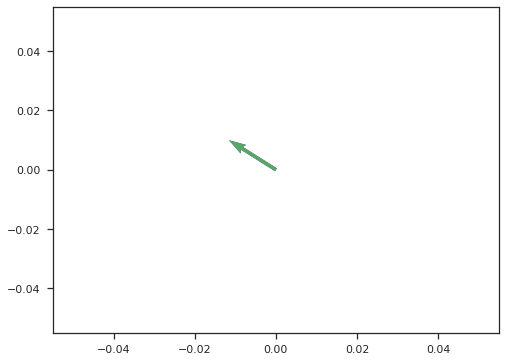

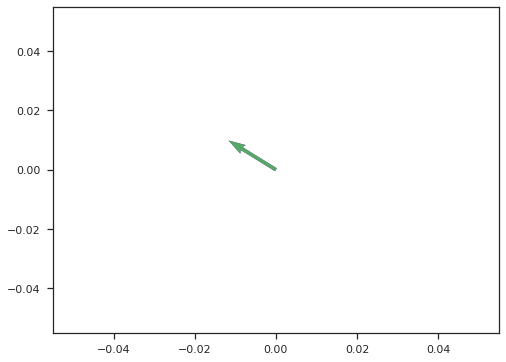

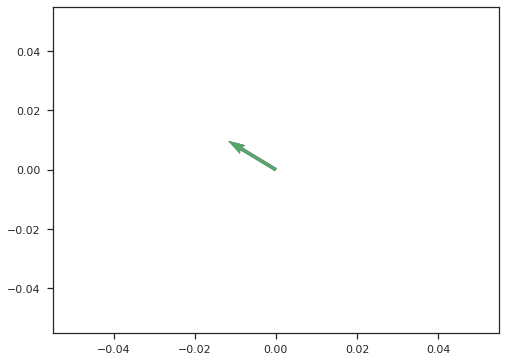

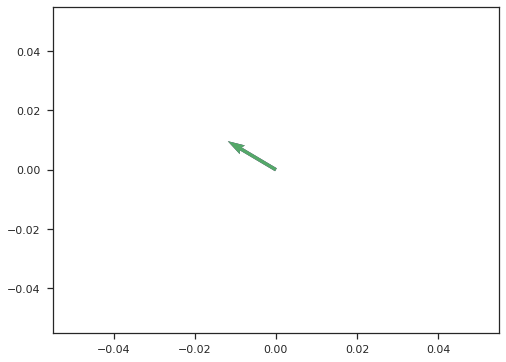

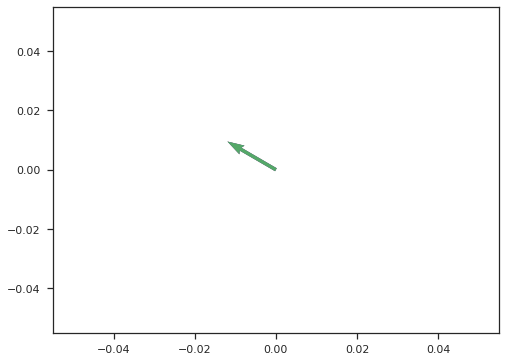

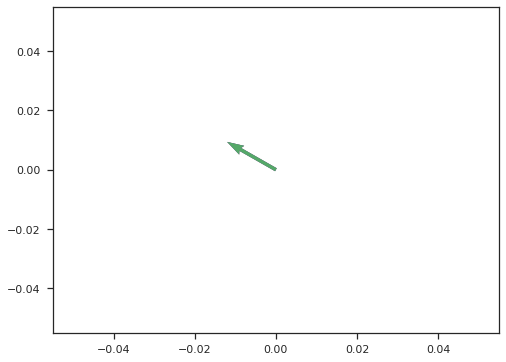

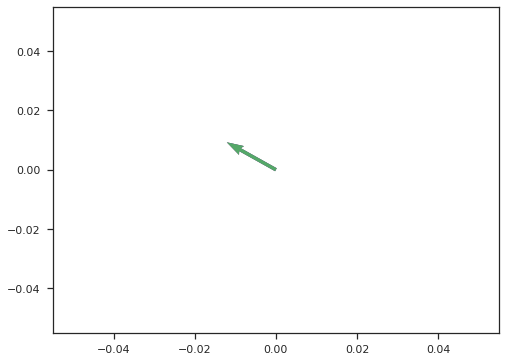

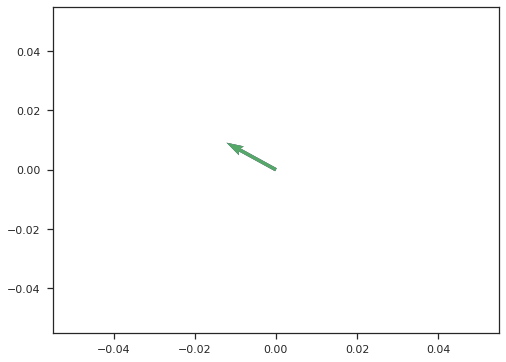

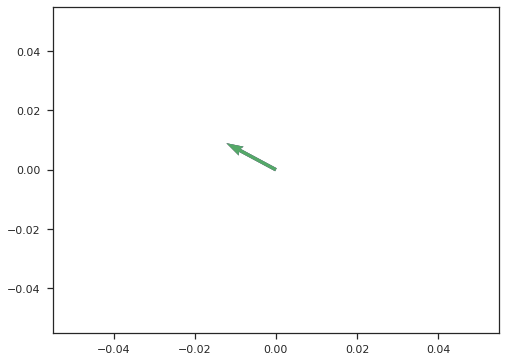

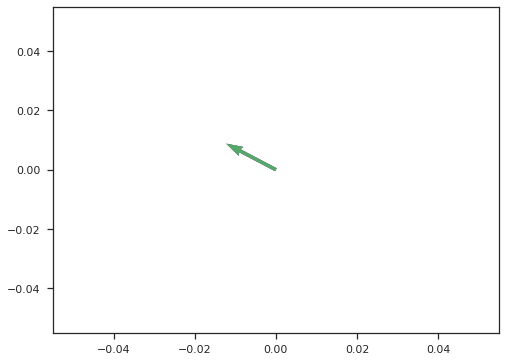

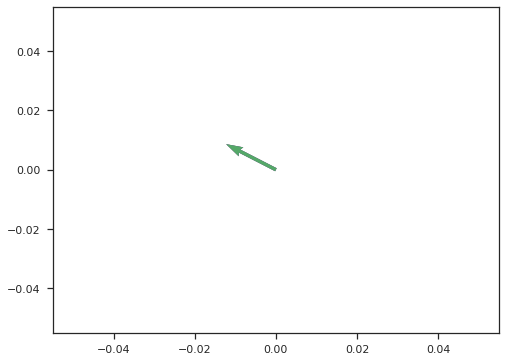

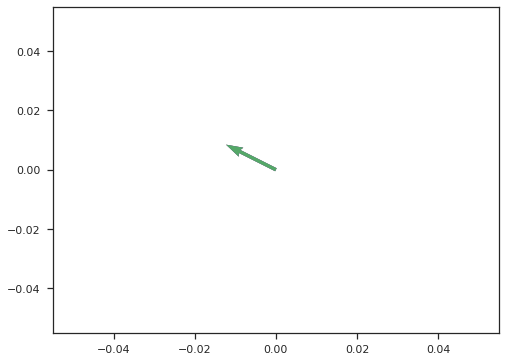

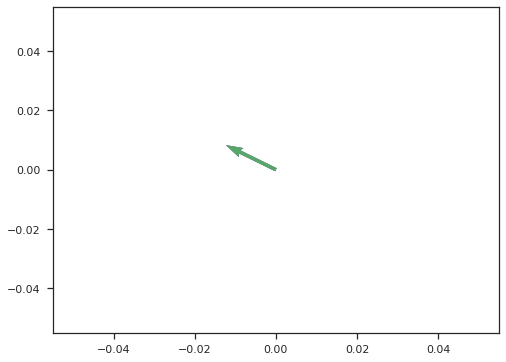

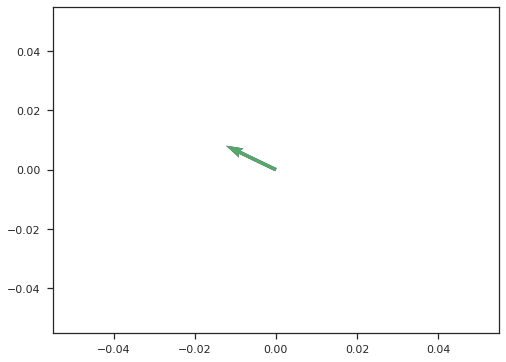

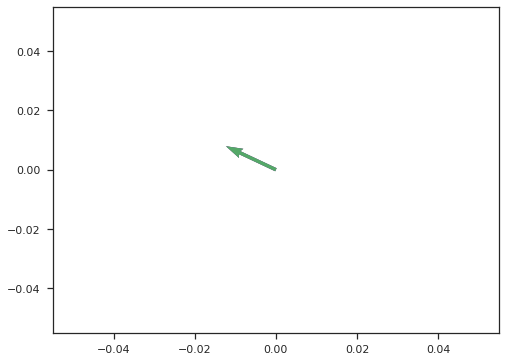

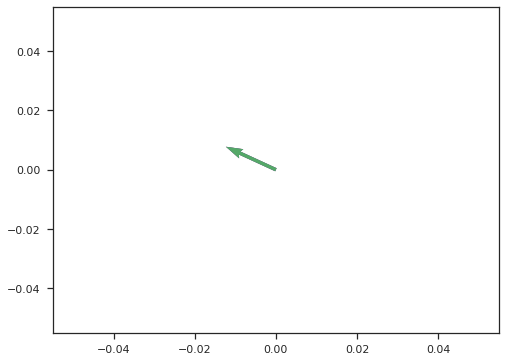

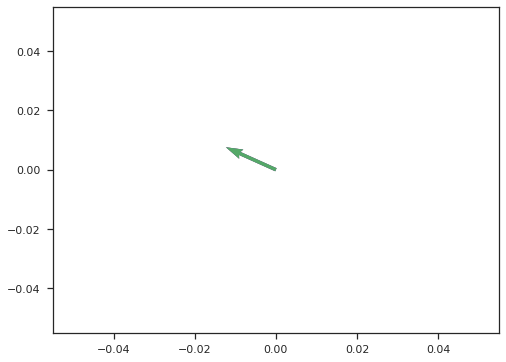

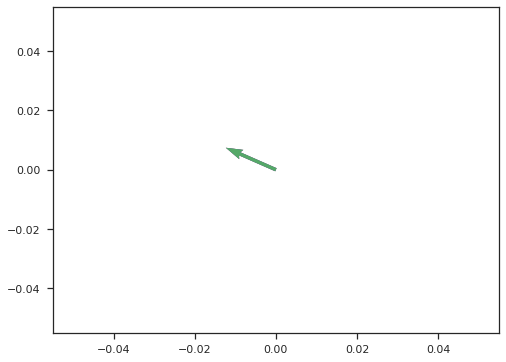

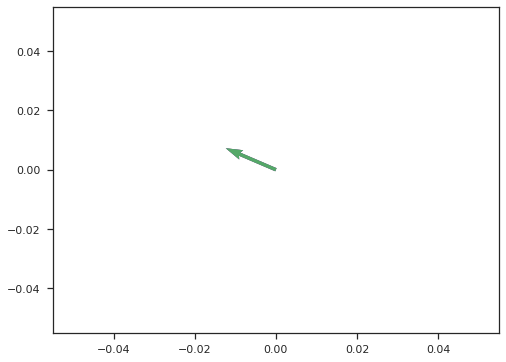

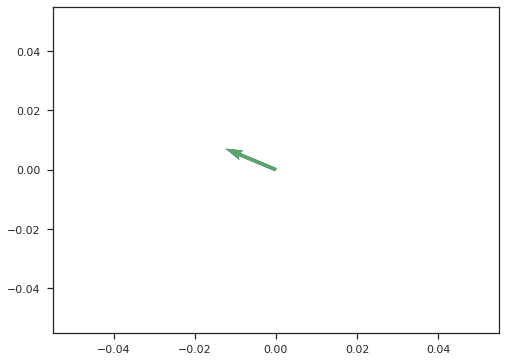

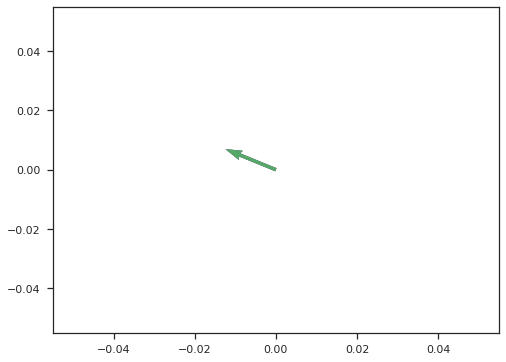

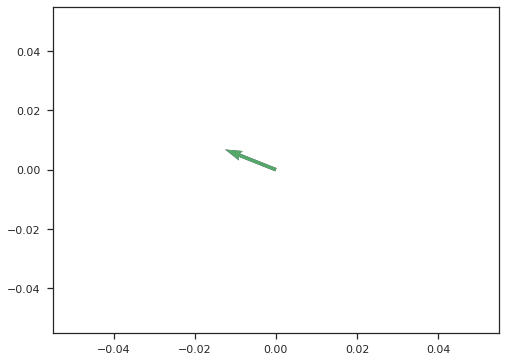

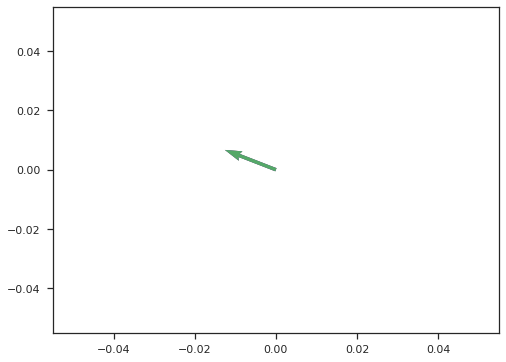

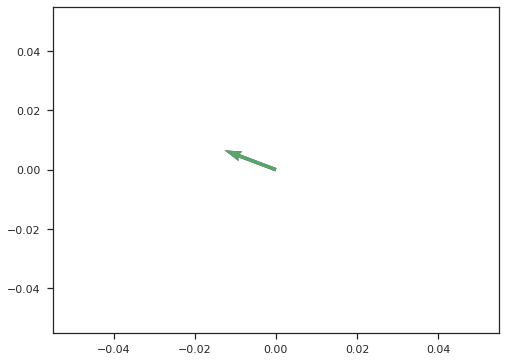

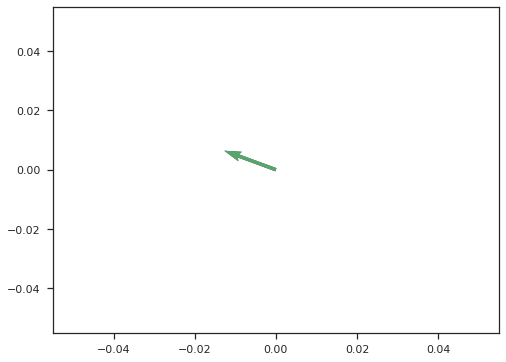

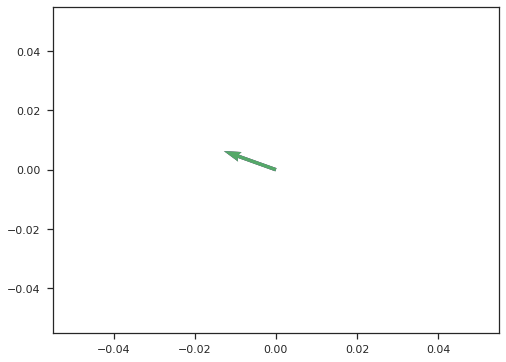

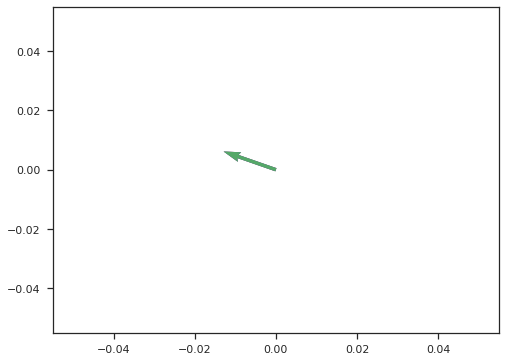

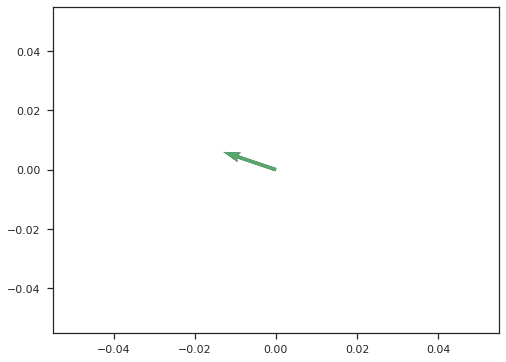

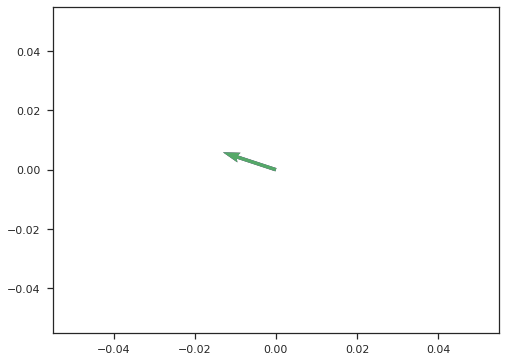

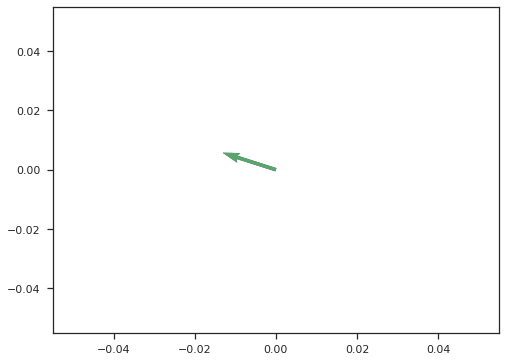

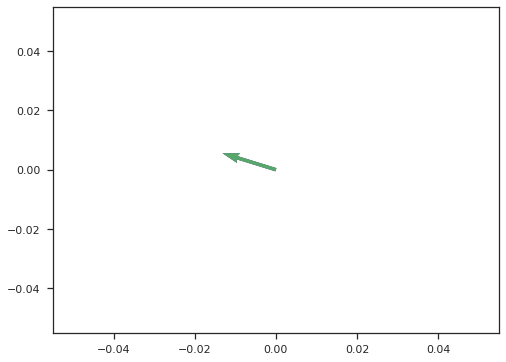

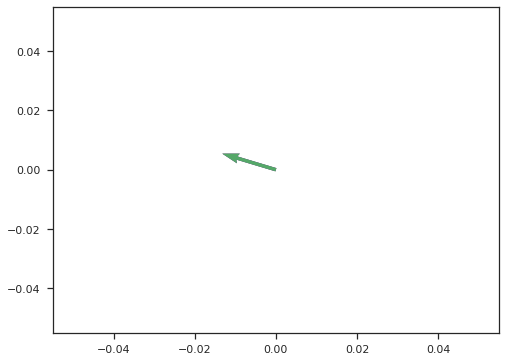

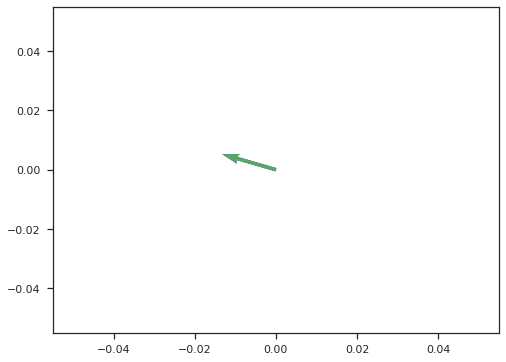

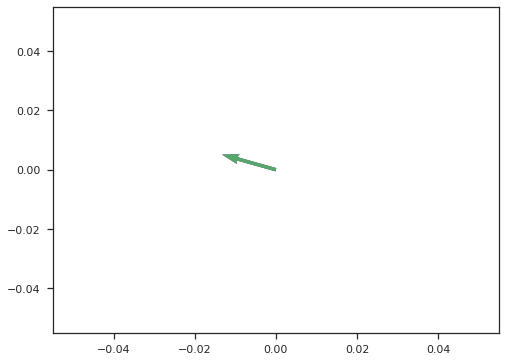

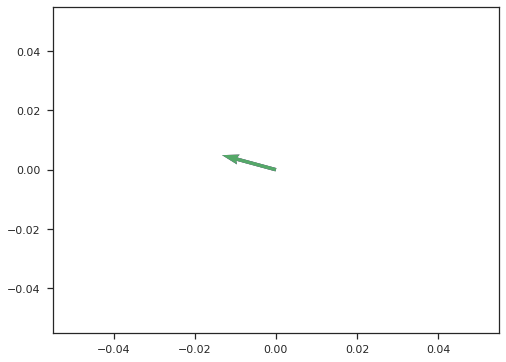

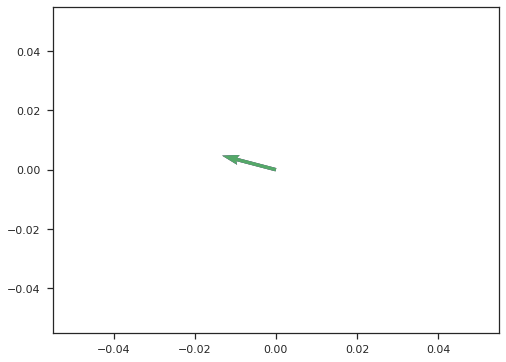

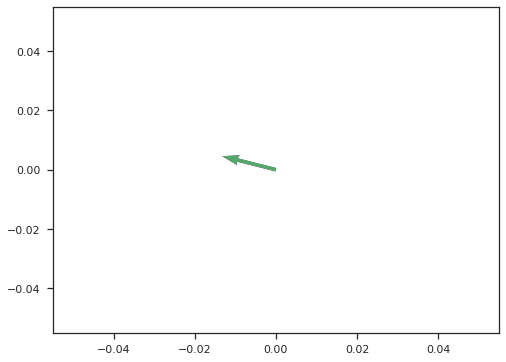

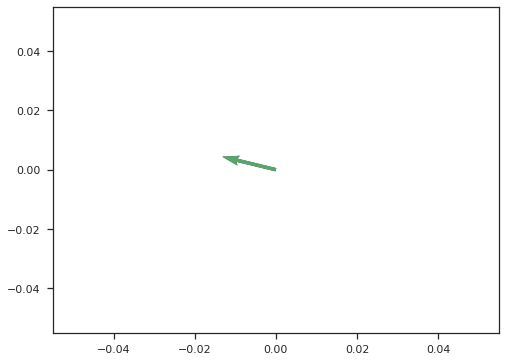

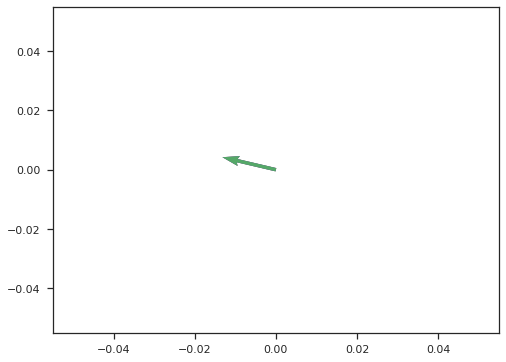

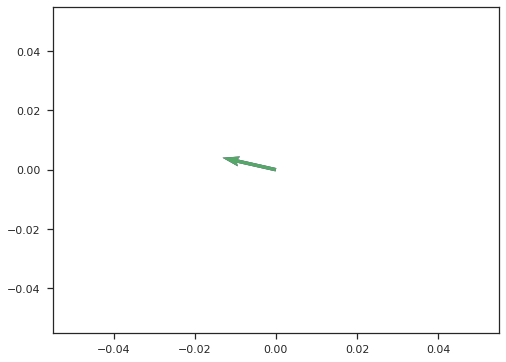

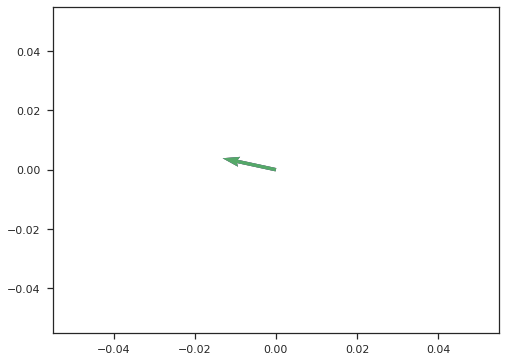

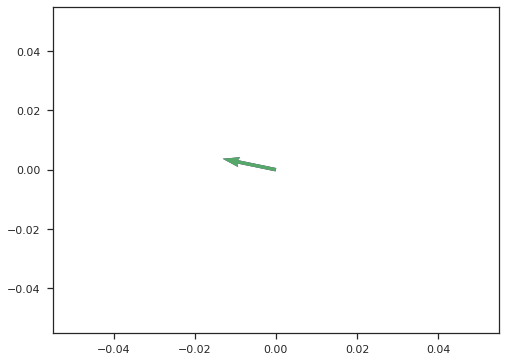

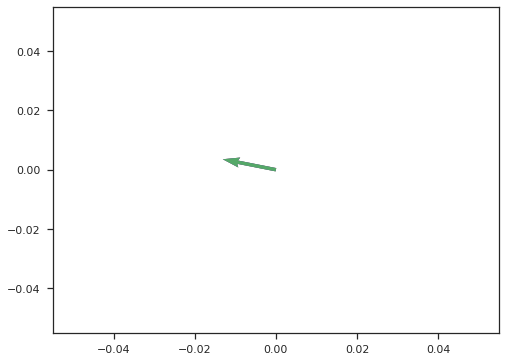

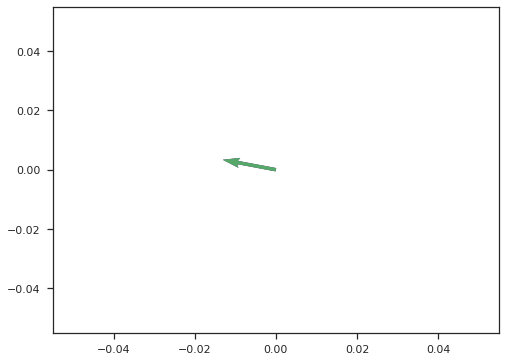

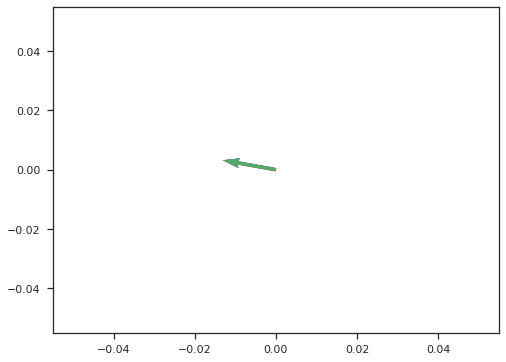

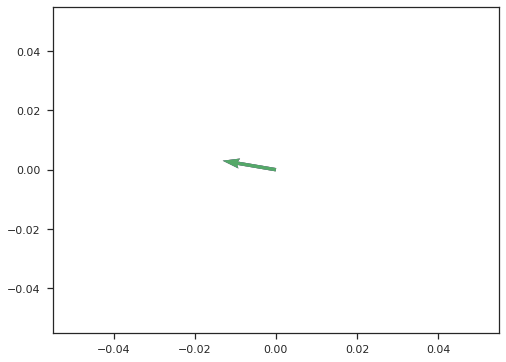

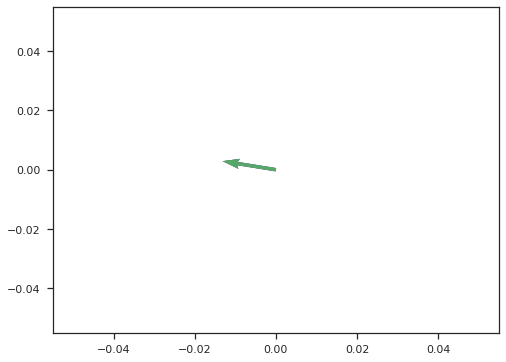

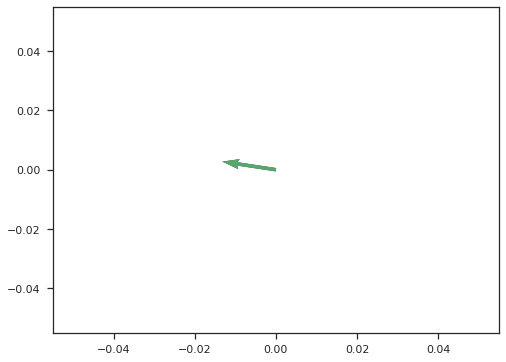

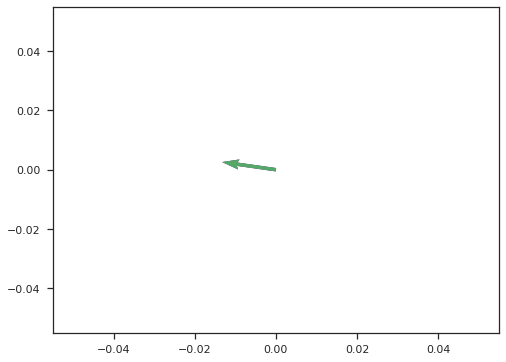

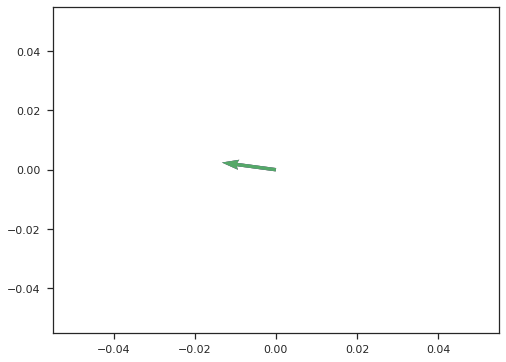

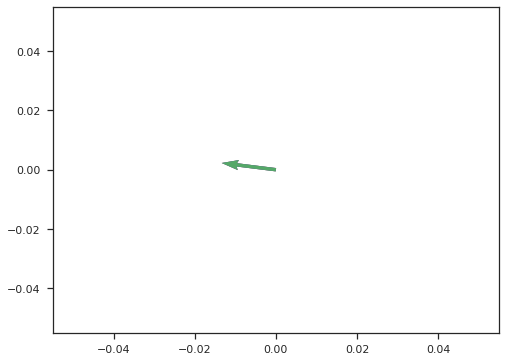

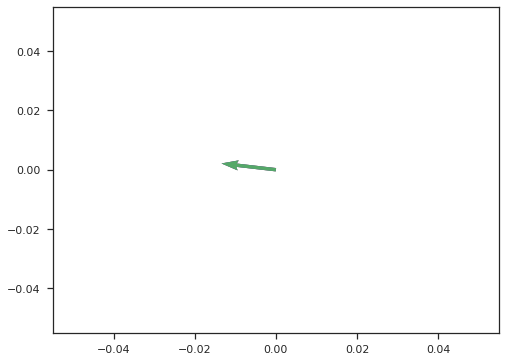

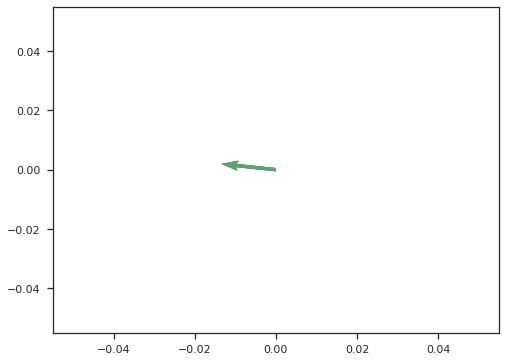

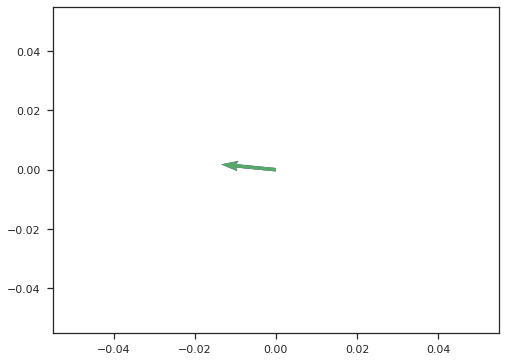

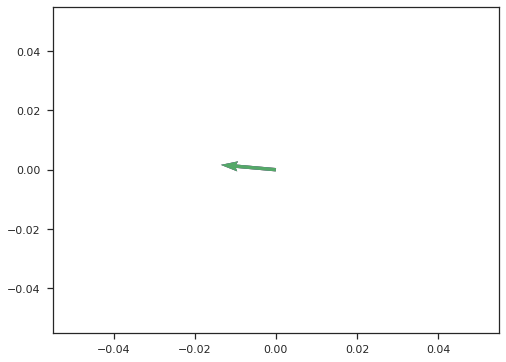

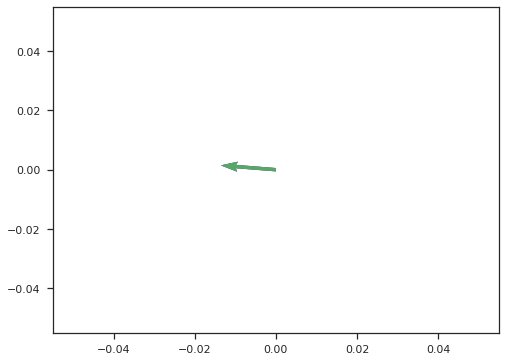

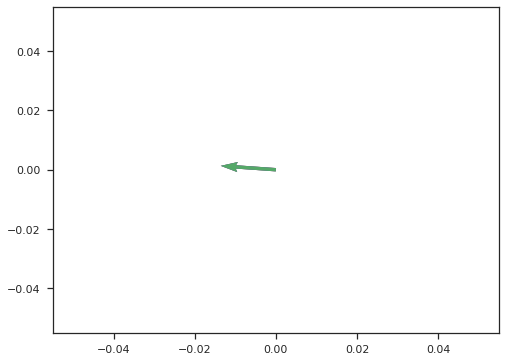

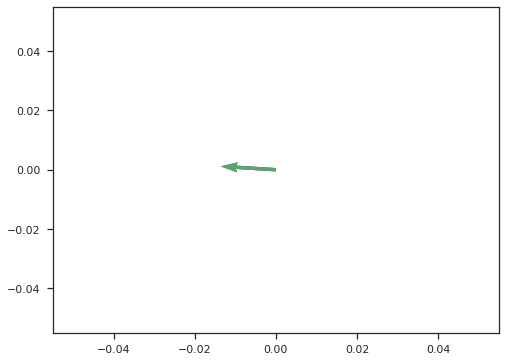

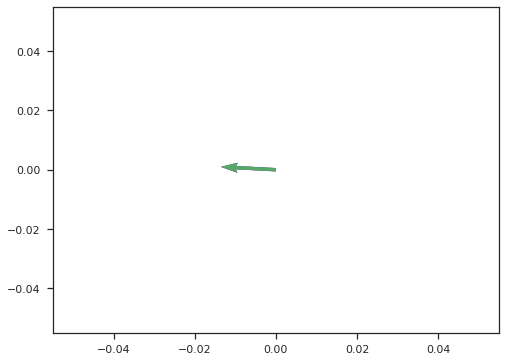

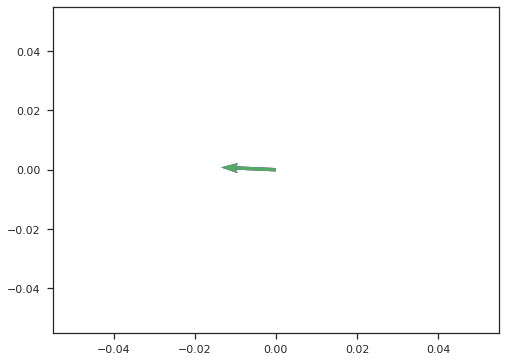

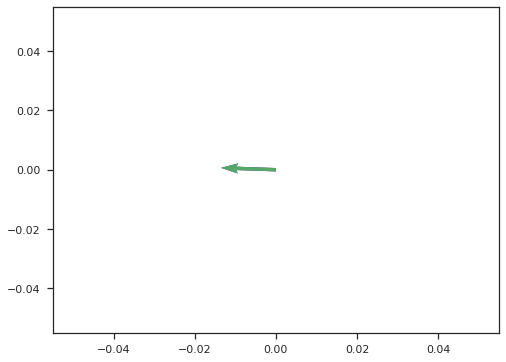

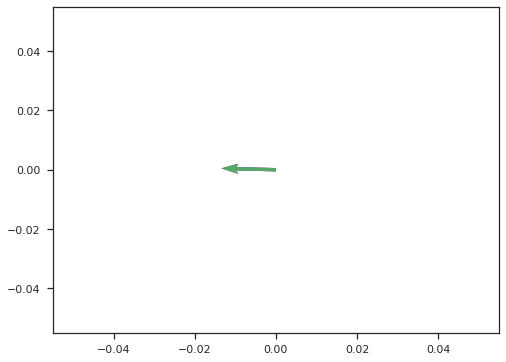

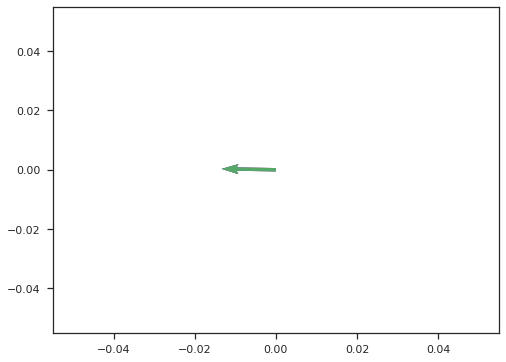

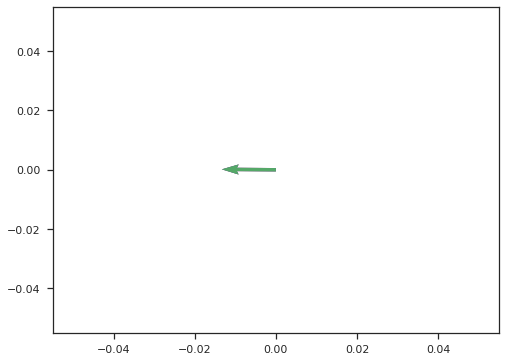

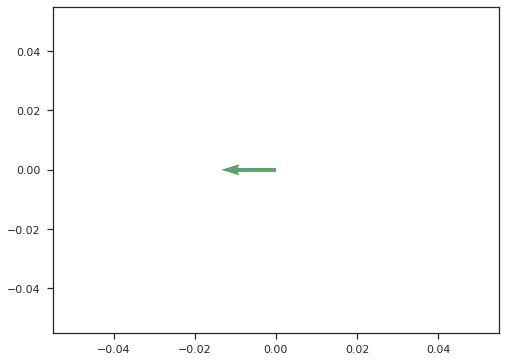

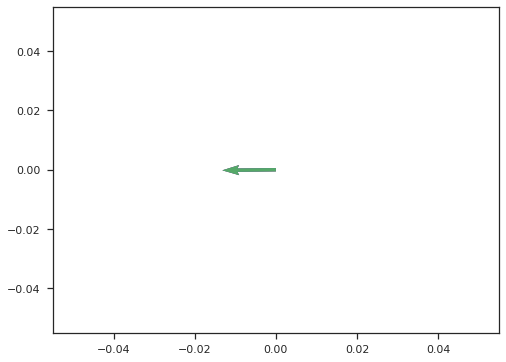

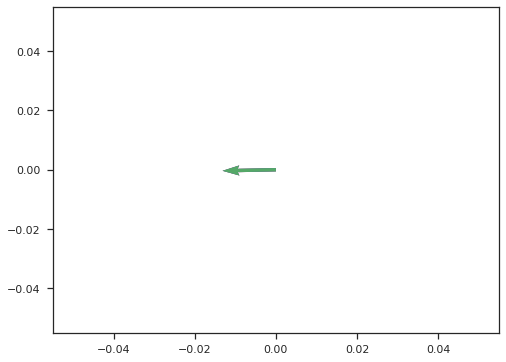

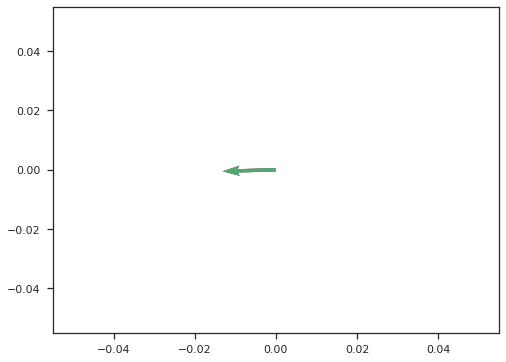

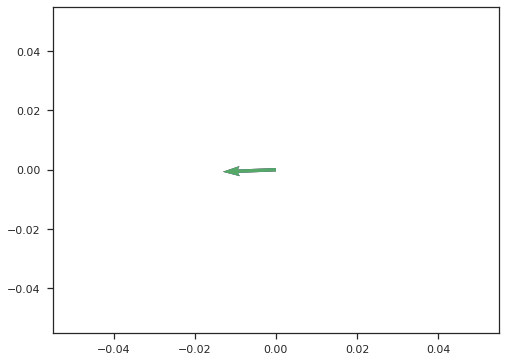

KeyboardInterrupt: 

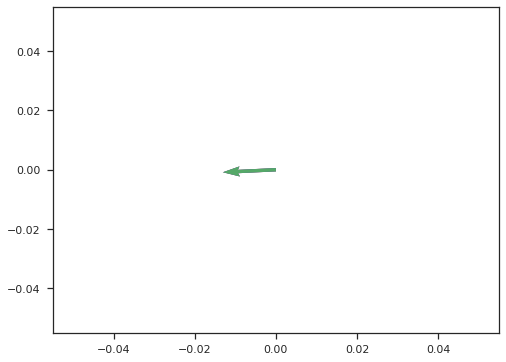

In [610]:
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point
#origin = np.zeros(v_ea[0,::100].shape)
for i in range(0, int(len(v_ea[0])/50)):
    plt.quiver(*origin, v_ea[0,i]*1000, v_ea[1,i]*1000, color=['r','b','g'], scale=21)
    plt.savefig("./plots/moon_gif/{}.png".format(i))
    #plt.show()
    plt.close()

In [609]:
import imageio.v2 as imageio
with imageio.get_writer('./plots/moon_gif/moon.gif', mode='I') as writer:
    for fname in os.listdir('./plots/moon_gif'):
        if fname[-3:] == 'png':
            image = imageio.imread('./plots/moon_gif/'+fname)
            writer.append_data(image)

In [580]:
v_ea.shape

(3, 87624)

In [596]:
int(len(v_ea[0])/10)

8762

In [324]:
for i in range(40):
    print(get_name(i))

('Pallas', 7.8132214)
('Vesta', 5.34212766)
('Ceres', 9.07417)
('Iris', 7.139)
('Hygiea', 13.828)
('Davida', 5.1297)
('Juno', 7.21)
('Europa', 5.6304)
('Eunomia', 6.083)
('Fortuna', 7.4432)
('Interamnia', 8.727)
('Flora', 12.865)
('Metis', 5.079)
('Amphitrite', 5.3921)
('Hebe', 7.2745)
('Patientia', 9.727)
('Julia', 11.387)
('Sylvia', 5.184)
('Doris', 11.89)
('Eugenia', 5.699)
('Prokne', 15.679)
('Winchester', 9.4146)
('Herculina', 9.405)
('Eukrate', 12.093)
('Nuwa', 8.1347)
('Nemausa', 7.783)
('Cybele', 6.0814)
('Laetitia', 5.138)
('Elektra', 5.225)
('Camilla', 4.844)
('Eunike', 21.797)
('Thisbe', 6.042)
('Minerva', 5.982)
('Ino', 6.15)
('Siegena', 9.763)
('Egeria', 7.045)
('Euphrosyne', 5.53)
('Peraga', 13.7128)
('Psyche', 4.196)
('Ursula', 16.899)


In [27]:
#name = 'Moon'

fake_times = False

if fake_times:
    times = ['2013-01-01T00:00:00', '2013-01-02T00:00:00']
    times = Time(times, format='isot', scale='utc')
    dt = times[1] - times[0]
    times = times[0] + dt * np.linspace(0., 3650, 1000)#3651*24)
else: 
    #times = Time(times, format='mjd')
    times = times

In [ ]:
if fake_times:
    dic = {'ctime':times.unix, 'eta':phase_obs}

    with open('{}_eta_comp.pk'.format(name), 'wb') as f:
        pk.dump(dic, f)